#Триангуляция по 3-м камерам

##Внешняя калибровка

In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install numpy==1.23.5 mediapipe==0.10.21

In [ ]:
  import cv2
  import numpy as np
  import mediapipe as mp
  from google.colab.patches import cv2_imshow
  import cv2
  import os
  from IPython.display import display, HTML, clear_output
  import base64
  import numpy as np
  from google.colab import output
  import json
  import asyncio
  import time
  import nest_asyncio
  from IPython.display import display, HTML, clear_output
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  import csv

In [ ]:
#@title Реализация на JavaScript внешней калибровки - ДЛЯ ТЕСТИРОВАНИЯ....
# Глобальная переменная для хранения изображений
image_buffer = []

# Функция для отображения всех накопленных изображений
def display_all_images():
    for img in image_buffer:
        plt.figure(figsize=(16, 12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


nest_asyncio.apply()  # Применяем patch для вложения циклов событий

# Асинхронная функция для завершения отметки точек
async def get_coords(timeout=120):
    """
    Функция для получения координат точек с таймаутом.
    """
    start_time = time.time()
    while True:
        elapsed_time = time.time() - start_time
        if elapsed_time > timeout:
            print("Время ожидания истекло. Прерывание процесса...")
            return None

        json_coords = output.eval_js('window.colab_coords || null')
        if json_coords is not None:
            coords = np.array(json.loads(json_coords))  # Преобразуем JSON в массив NumPy
            clear_output()
            print(f"Отмечено {len(coords)} точек на изображении.")
            print(coords)
            return coords
        await asyncio.sleep(0.1)  # Асинхронное ожидание

# Обертка для вызова асинхронной функции
def run_get_coords():
    import asyncio
    loop = asyncio.get_event_loop()  # Получаем текущий event loop
    try:
        return loop.run_until_complete(get_coords())  # Выполняем асинхронную задачу
    except KeyboardInterrupt:
        print("Прервано пользователем.")
        return None

# Функция для отображения изображения и получения координат
def imgp_objp_visualizer_clicker_js(img):
    """
    Функция для получения координат точек на изображении с использованием canvas и JavaScript.
    """
    # Конвертируем изображение в формат base64 для отображения в HTML
    _, img_encoded = cv2.imencode('.jpg', img)
    img_base64 = base64.b64encode(img_encoded).decode('utf-8')

    # Создаем HTML-код с canvas
    display(HTML(f'''
        <h3>Кликните на изображении для отметки точек.</h3>
        <canvas id="canvas" style="border:1px solid #000000;"></canvas>
        <button id="finishButton">Finish</button>  <!-- Кнопка всегда активна -->
        <p>Отмеченные точки:</p>
        <ul id="coordsList"></ul>
        <script>
            // Глобальные переменные
            var coords = [];
            var finishButton = document.getElementById('finishButton');
            var coordsList = document.getElementById('coordsList');

            // Создаем холст и загружаем изображение
            var img = new Image();
            img.src = 'data:image/jpeg;base64,{img_base64}';
            img.onload = function() {{
                var canvas = document.getElementById('canvas');
                canvas.width = img.width;
                canvas.height = img.height;
                var ctx = canvas.getContext('2d');
                ctx.drawImage(img, 0, 0);

                // Обработка кликов
                canvas.onclick = function(event) {{
                    var rect = canvas.getBoundingClientRect();
                    var x = event.clientX - rect.left;
                    var y = event.clientY - rect.top;

                    // Сохраняем координаты
                    coords.push([x, y]);
                    google.colab.kernel.invokeFunction('notebook.handle_click', [x, y], {{}});

                    // Отмечаем точку красным кругом
                    ctx.beginPath();
                    ctx.arc(x, y, 5, 0, 2 * Math.PI);
                    ctx.fillStyle = 'red';
                    ctx.fill();

                    // Обновляем список координат
                    var li = document.createElement('li');
                    li.textContent = '(' + x + ', ' + y + ')';
                    coordsList.appendChild(li);
                }};

                // Кнопка завершения
                finishButton.addEventListener('click', function() {{
                    if (coords.length === 0) {{
                        alert("Необходимо отметить хотя бы одну точку!");
                        return;
                    }}
                    console.log("Кнопка 'Finish' нажата. Отправка координат:", coords);
                    window.colab_coords = JSON.stringify(coords);  // Сохраняем координаты в глобальную переменную
                }});
            }};
        </script>
    '''))

    # Возвращаем функцию для получения координат
    return run_get_coords

# Функция для сохранения калибровочных данных в YAML
def save_calibration_to_yaml(calib_dir, cam_name, reprojection_error, R, T, file_name=None):
    """
    Сохраняет калибровочные данные (включая внешние параметры) для конкретной камеры в YAML-файл.

    :param calib_dir: Директория для сохранения файла.
    :param cam_name: Имя камеры.
    :param reprojection_error: Ошибка повторной проекции.
    :param file_name: Необязательное имя файла (если None, используется стандартное имя).
    """
    if file_name is None:
        file_name = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam_name}_extrinsics.yaml')

    # Создаем объект FileStorage для записи данных
    cv_file = cv2.FileStorage(file_name, cv2.FILE_STORAGE_WRITE)

    # Записываем данные
    cv_file.write("camera_name", cam_name)
    cv_file.write("reprojection_error", reprojection_error)
    cv_file.write("rotation_matrix", R)
    cv_file.write("translation_vector", T)

    # Закрываем файл
    cv_file.release()

    print(f"Калибровочные данные для камеры {cam_name} успешно сохранены в {file_name}")

# Функция для чтения внутренних параметров камеры из YAML
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')

    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    else:  print(f"Файл внутренних параметров {yaml_file} найден.")
    print (yaml_file)
    cv_file = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)

    if cv_file.isOpened():
        # Читаем данные
        ret = cv_file.getNode("reprojection_error").real()  # Средняя ошибка повторной проекции

        K = cv_file.getNode("camera_matrix").mat()  # Средняя ошибка повторной проекции
        D = cv_file.getNode("distortion_coefficients").mat()  # Матрица внутренних параметров

        print (K, D)
        #fs.release()
        return K, D
    else:
        print(f"Ошибка при открытии файла {yaml_file}.")
        return None, None

# Основная функция для калибровки внешних параметров
def calibrate_extrinsics(calib_dir, extrinsics_config_dict):
    try:
        extrinsics_cam_listdirs_names = next(os.walk(os.path.join(calib_dir, 'extrinsics')))[1]
        print (extrinsics_cam_listdirs_names)
    except StopIteration:
        print(f"Ошибка: Папка {os.path.join(calib_dir, 'extrinsics')} не найдена.")
        return [], [], []

    extrinsics_method = extrinsics_config_dict.get('extrinsics_method')
    if extrinsics_method != 'scene':
        print('Ошибка: В данном примере поддерживается только метод "scene".')
        return [], [], []

    object_coords_3d = np.array(extrinsics_config_dict['scene']['object_coords_3d'], np.float32)
    extrinsics_extension = extrinsics_config_dict['scene']['extrinsics_extension']
    show_reprojection_error = extrinsics_config_dict['scene']['show_reprojection_error']

    # Количество точек 3D
    pcs_points = len(object_coords_3d)

    R, T, reprojection_errors = [], [], []  # Список для хранения ошибок повторной проекции

    for i, cam in enumerate(extrinsics_cam_listdirs_names):
        print(f'\nОбработка камеры {cam}:')

        # Загрузка внутренних параметров камеры
        K, D = load_intrinsics_opencv(calib_dir, cam)
        if K is None or D is None:
            print(f"Пропуск камеры {cam} из-за отсутствия или некорректных внутренних параметров.")
            continue

        # Читаем первое изображение для камеры
        img_files = sorted([
            f for f in os.listdir(os.path.join(calib_dir, 'extrinsics', cam))
            if f.endswith(extrinsics_extension)
        ])
        if not img_files:
            print(f"Для камеры {cam} не найдено изображений. Пропуск...")
            continue

        img_path = os.path.join(calib_dir, 'extrinsics', cam, img_files[0])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Не удалось прочитать изображение: {img_path}. Пропуск...")
            continue
        print(f"Использование изображения: {img_path}")

        # Отображение графика расположения точек object_coords_3d
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            object_coords_3d[:, 0],  # Координата X
            object_coords_3d[:, 1],  # Координата Y
            object_coords_3d[:, 2],  # Координата Z
            c='r', marker='o'
        )

        # Добавление нумерации точек
        for j, point in enumerate(object_coords_3d):
            ax.text(point[0], point[1], point[2], str(j), color="blue", fontsize=10)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Расположение точек object_coords_3d')
        plt.show()

        # Нахождение углов вручную (используем JavaScript-версию)
        get_coords_func = imgp_objp_visualizer_clicker_js(img)

        # Ожидаем результатов от JavaScript
        coords = get_coords_func()
        print(coords)

        if len(coords) < pcs_points:
            print(f'Для калибровки необходимо отметить {pcs_points} точек. Пропуск...')
            continue

        # Преобразуем координаты в формат NumPy
        imgp = np.array(coords, dtype=np.float32)
        objp = object_coords_3d

        # Вычисление внешних параметров
        try:
            _, rvec, tvec = cv2.solvePnP(objp, imgp, K, D)
            R_mat = cv2.Rodrigues(rvec)[0]  # Преобразование Rodrigues в матрицу поворота
            T_vec = tvec.flatten()

            R.append(R_mat)
            T.append(T_vec)

            # Проверка результатов калибровки
            if show_reprojection_error:
                proj_points, _ = cv2.projectPoints(objp, rvec, tvec, K, D)

                # Создаем копию изображения для отображения точек
                img_with_points = img.copy()

                # Рисуем предсказанные точки (зеленый цвет)
                proj_points = proj_points.squeeze().astype(np.int32)
                for point in proj_points:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 255, 0), -1)  # Зеленые круги

                # Рисуем отмеченные точки (красный цвет)
                imgp_int = imgp.astype(np.int32)
                for point in imgp_int:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 0, 255), -1)  # Красные круги

                # Сохраняем изображение в буфер
                image_buffer.append(img_with_points)
                print(f"Проекция и отмеченные точки для камеры {cam} успешно нанесены на изображение.")

                # Вычисляем ошибку повторной проекции
                reprojection_error = np.mean(np.linalg.norm(imgp.squeeze() - proj_points, axis=1))
                reprojection_errors.append(reprojection_error)  # Добавляем ошибку в список
                print(f"Ошибка повторной проекции для камеры {cam}: {reprojection_error:.4f} пикселей")

                # Сохраняем параметры калибровки в YAML
                save_calibration_to_yaml(calib_dir, cam, reprojection_error, R_mat, T_vec)

            else:
                reprojection_errors.append(None)  # Если не показываем ошибку, добавляем None

            print(f"Внешние параметры для камеры {cam} успешно вычислены.")

        except Exception as e:
            print(f"Ошибка при вычислении внешних параметров для камеры {cam}: {e}")
            reprojection_errors.append(None)  # В случае ошибки добавляем None

    # Отображаем все сохраненные изображения
    display_all_images()

    return R, T, reprojection_errors

Отмечено 8 точек на изображении.
[[ 921.        780.546875]
 [1407.        655.546875]
 [1264.        598.546875]
 [ 797.        700.546875]
 [ 867.        565.546875]
 [1415.        468.546875]
 [1315.        437.546875]
 [ 778.        520.546875]]
[[ 921.        780.546875]
 [1407.        655.546875]
 [1264.        598.546875]
 [ 797.        700.546875]
 [ 867.        565.546875]
 [1415.        468.546875]
 [1315.        437.546875]
 [ 778.        520.546875]]
Проекция и отмеченные точки для камеры cam1 успешно нанесены на изображение.
Ошибка повторной проекции для камеры cam1: 5.9546 пикселей
Калибровочные данные для камеры cam1 успешно сохранены в /content/drive/MyDrive/Karate_2/calibrate_1+2+4/extrinsics/calibration_cam1_extrinsics.yaml
Внешние параметры для камеры cam1 успешно вычислены.


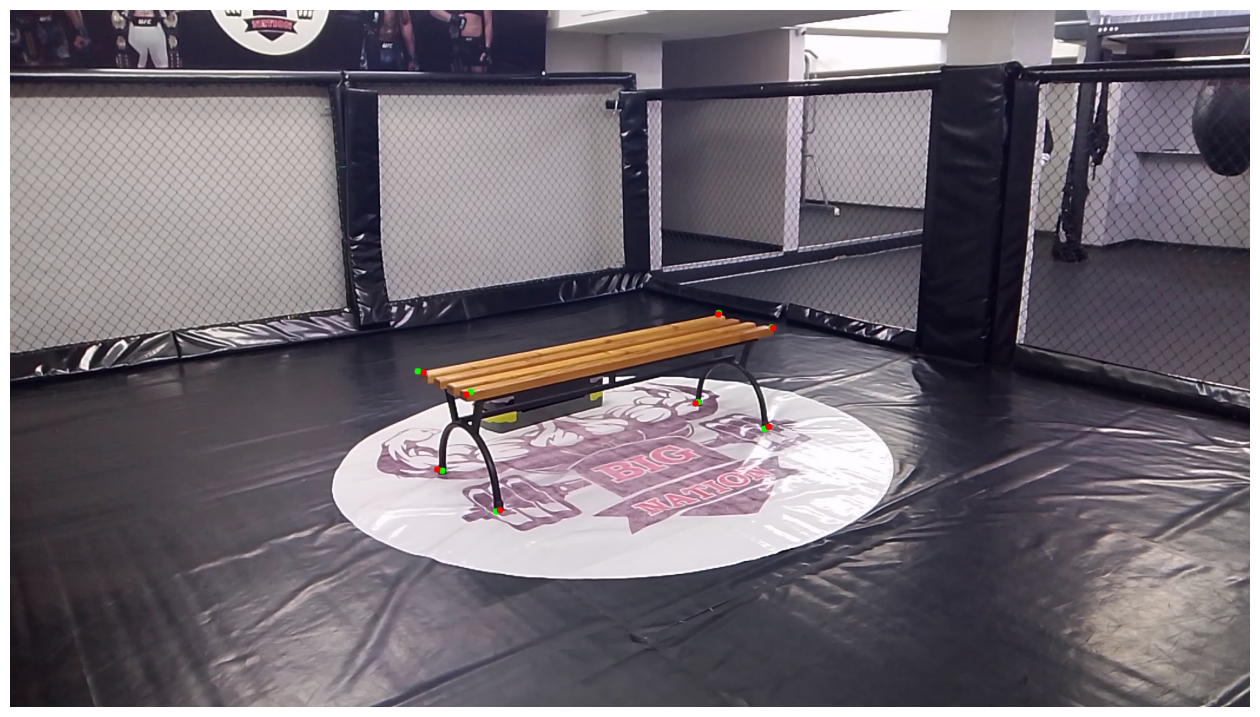

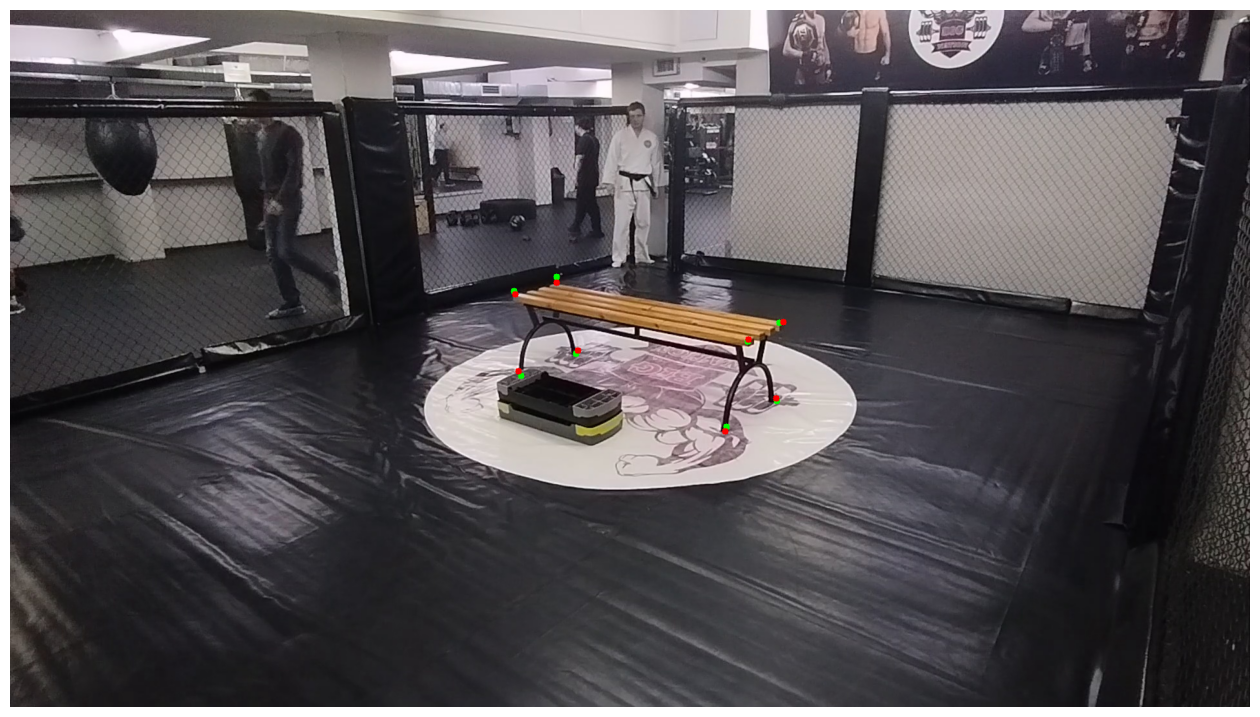

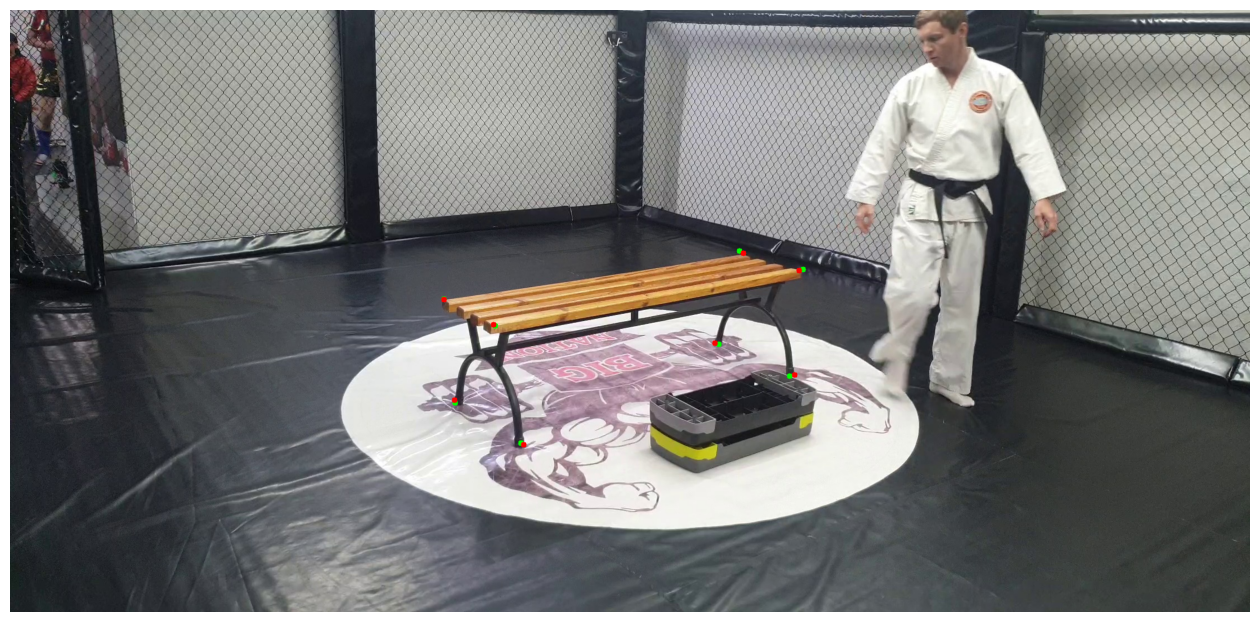

Внешние параметры успешно рассчитаны:

Камера 1:
Матрица поворота:
 [[-0.80026105  0.59950501 -0.01326648]
 [ 0.18066465  0.21995005 -0.95863562]
 [-0.5717889  -0.76955553 -0.28432682]]
Вектор перемещения:
 [0.25135136 0.20750131 4.63070041]
Ошибка повторной проекции для камеры: 5.9411 пикселей

Камера 2:
Матрица поворота:
 [[ 0.82399295  0.56653343  0.00868829]
 [ 0.18721801 -0.25776187 -0.94789674]
 [-0.53477568  0.78268684 -0.31845923]]
Вектор перемещения:
 [-1.11822831  0.07571146  9.60747452]
Ошибка повторной проекции для камеры: 6.0592 пикселей

Камера 3:
Матрица поворота:
 [[ 0.753135   -0.65459306  0.06554086]
 [-0.14361281 -0.26081578 -0.95464679]
 [ 0.64199925  0.7095654  -0.29043744]]
Вектор перемещения:
 [-0.88155621  0.59930006  5.57308522]
Ошибка повторной проекции для камеры: 5.9546 пикселей


In [ ]:
# Запуск калибровки - перебор калибровки

# Настройки
calib_dir = '/content/drive/MyDrive/Karate_2/calibrate_1+2+4'

# Конфигурация для метода scene
extrinsics_config_dict = {
    'extrinsics_method': 'scene',
    'scene': {
        'object_coords_3d': [
            [0, 0, 0], [1.46, 0, 0], [1.46, 0.51, 0], [0, 0.51, 0],
            [-0.09, 0.06, 0.49], [1.55, 0.06, 0.49], [1.5, 0.45, 0.49], [-0.09, 0.45, 0.49]
        ],  # Задайте координаты объектов в метрах
        'extrinsics_extension': 'jpg',  # Расширение файлов с изображениями
        'show_reprojection_error': True  # Показывать ли ошибку повторной проекции
    }
}

# Подсчет количества 3D точек
pcs_points = len(extrinsics_config_dict['scene']['object_coords_3d'])

# Вывод результата
print(f"Количество отмеченных 3D точек: {pcs_points}")

# Запуск калибровки
print("Начало процесса калибровки внешних параметров...")
R, T, reprojection_errors = calibrate_extrinsics(calib_dir, extrinsics_config_dict)

if R and T and reprojection_errors:
    print("Внешние параметры успешно рассчитаны:")
    for i, (r, t, re) in enumerate(zip(R, T, reprojection_errors)):
        print(f"\nКамера {i+1}:")
        print("Матрица поворота:\n", r)
        print("Вектор перемещения:\n", t)
        if re is not None:
            print(f"Ошибка повторной проекции для камеры: {re:.4f} пикселей")
        else:
            print("Ошибка повторной проекции не рассчитана.")
else:
    print("Не удалось рассчитать корректные внешние параметры.")

In [ ]:
#@title Вывод калибровочной конфигурации
import os
# Функция для загрузки калибровочных данных
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("distortion_coefficients").mat()
    fs.release()
    return camera_matrix, dist_coeffs

def load_extrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam}_extrinsics.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внешних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    rotation_matrix = fs.getNode("rotation_matrix").mat()
    translation_vector = fs.getNode("translation_vector").mat()
    fs.release()
    return rotation_matrix, translation_vector

# Загрузка калибровочных данных
calib_dir = '/content/drive/MyDrive/Karate_2/triang_3'
cams = ['cam1', 'cam2', 'cam4']

intrinsics = {}
extrinsics = {}

for cam in cams:
    camera_matrix, dist_coeffs = load_intrinsics_opencv(calib_dir, cam)
    rotation_matrix, translation_vector = load_extrinsics_opencv(calib_dir, cam)
    intrinsics[cam] = {'camera_matrix': camera_matrix, 'dist_coeffs': dist_coeffs}
    extrinsics[cam] = {'rotation_matrix': rotation_matrix, 'translation_vector': translation_vector}

In [ ]:
intrinsics

{'cam1': {'camera_matrix': array([[2.51383283e+03, 0.00000000e+00, 1.31337399e+03],
         [0.00000000e+00, 2.49071320e+03, 5.08048986e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[ 4.78934978e-01,  5.76955632e+00, -5.87764053e-03,
           4.05717282e-02, -7.84471007e+01]])},
 'cam2': {'camera_matrix': array([[2.51878976e+03, 0.00000000e+00, 1.08548575e+03],
         [0.00000000e+00, 2.50721644e+03, 5.47674933e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[ 2.13204690e-01, -3.80116441e-01,  3.11225881e-04,
           4.71316699e-03, -2.39162019e+00]])},
 'cam4': {'camera_matrix': array([[1.33421977e+03, 0.00000000e+00, 9.92940940e+02],
         [0.00000000e+00, 1.33111698e+03, 5.48896195e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[-2.94448256e-02,  8.96096431e-01,  1.07542936e-03,
          -3.36732650e-03, -2.85529189e+00]])}}

In [ ]:
extrinsics

{'cam1': {'rotation_matrix': array([[ 0.753135  , -0.65459306,  0.06554086],
         [-0.14361281, -0.26081578, -0.95464679],
         [ 0.64199925,  0.7095654 , -0.29043744]]),
  'translation_vector': array([[-0.88155621],
         [ 0.59930006],
         [ 5.57308522]])},
 'cam2': {'rotation_matrix': array([[ 0.82399295,  0.56653343,  0.00868829],
         [ 0.18721801, -0.25776187, -0.94789674],
         [-0.53477568,  0.78268684, -0.31845923]]),
  'translation_vector': array([[-1.11822831],
         [ 0.07571146],
         [ 9.60747452]])},
 'cam4': {'rotation_matrix': array([[-0.80026105,  0.59950501, -0.01326648],
         [ 0.18066465,  0.21995005, -0.95863562],
         [-0.5717889 , -0.76955553, -0.28432682]]),
  'translation_vector': array([[0.25135136],
         [0.20750131],
         [4.63070041]])}}

# Получение координат поз - 2-й спортсмен


In [ ]:
#@title Сохранение координат в пикселях поз с учетом приведения к одной частоте и нумерацией c начала видео
import subprocess
from pathlib import Path
import cv2
import pandas as pd
from tqdm import tqdm
import mediapipe as mp

# Функция для обрезки и изменения FPS
def trim_and_change_fps(input_path, output_path, start_time, end_time, target_fps=30):
    # Вычисляем длительность временного интервала
    duration = end_time - start_time

    # Команда FFmpeg для обрезки видео и изменения FPS
    command = [
        "ffmpeg",
        "-y",  # Разрешаем перезапись выходного файла
        "-i", str(input_path),  # Преобразуем Path в строку
        "-ss", str(start_time),  # Начало временного интервала
        "-t", str(duration),     # Длительность временного интервала
        "-filter:v", f"fps={target_fps}",  # Изменение частоты кадров
        "-c:a", "copy",          # Копируем аудиодорожку без изменений
        str(output_path)         # Преобразуем Path в строку
    ]

    print(f"Запуск команды FFmpeg: {' '.join(command)}")  # Выводим команду для отладки

    # Запускаем процесс FFmpeg и отслеживаем прогресс
    process = subprocess.Popen(
        command,
        stderr=subprocess.PIPE,
        universal_newlines=True
    )

    # Создаем прогресс-бар
    total_frames = None
    with tqdm(desc=f"Обработка {Path(output_path).name}", unit="frame") as pbar:
        for line in process.stderr:
            print(line.strip())  # Выводим логи FFmpeg для отладки
            if "frame=" in line:
                try:
                    # Извлекаем текущее количество обработанных кадров
                    current_frame = int(line.split("frame=")[1].split()[0])
                    if total_frames is None:
                        # Извлекаем общее количество кадров (если доступно)
                        total_frames = int(line.split("total=")[1].split()[0]) if "total=" in line else None
                    pbar.total = total_frames or current_frame
                    pbar.update(current_frame - pbar.n)
                except Exception:
                    pass  # Пропускаем строки, которые не удается распарсить
        process.wait()  # Ждем завершения процесса

    # Проверяем, что выходной файл существует и не пуст
    if not os.path.exists(output_path) or os.path.getsize(output_path) == 0:
        raise ValueError(f"FFmpeg не удалось обработать видео. Выходной файл пуст или отсутствует: {output_path}")

# Инициализация Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Создаем временную директорию для преобразованных видео
temp_dir = Path('/content/temp_resampled_videos')
temp_dir.mkdir(parents=True, exist_ok=True)

# Функция для получения длительности видео
def get_video_duration(video_path):
    command = [
        "ffprobe",
        "-i", video_path,
        "-show_entries", "format=duration",
        "-v", "quiet",
        "-of", "csv=p=0"
    ]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    duration = float(result.stdout.decode().strip())
    return duration

# Список видео
video_1 = '/content/drive/MyDrive/Karate_2/cam1.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/cam2.mp4'
video_4 = '/content/drive/MyDrive/Karate_2/cam4.mp4'
video_list = [video_1, video_2, video_4]


# Время начала и конца в секундах для каждого видео
time_intervals = {
    'cam1.mp4': (173, 217),
    'cam2.mp4': (258, 302),
    'cam4.mp4': (215, 259),
}

# Преобразуем видео: обрезаем до временных рамок и меняем FPS
resampled_videos = []
for video_path in video_list:
    video_name = Path(video_path).name
    start_time, end_time = time_intervals[video_name]
    resampled_video_path = temp_dir / video_name
    trim_and_change_fps(video_path, resampled_video_path, start_time, end_time, target_fps=30)
    resampled_videos.append(resampled_video_path)

# Функция для обработки видео и сохранения данных в датафрейм

def process_video(video_path, start_time, fps):
    cap = cv2.VideoCapture(str(video_path))  # Преобразуем Path в строку
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0
    data = []

    # Получаем разрешение видео
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Вычисляем смещение для номера кадра
    frame_offset = int(start_time * fps)

    # Создаем прогресс-бар с tqdm
    with tqdm(total=total_frames, desc=f"Обработка {Path(video_path).name}") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Конвертируем кадр в RGB для Mediapipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Обрабатываем кадр с помощью Mediapipe Pose
            results = pose.process(rgb_frame)

            # Если поза найдена, извлекаем координаты и вероятности
            row_data = {'frame_number': frame_count + frame_offset}  # Добавляем смещение
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                for i, landmark in enumerate(landmarks):
                    # Переводим нормализованные координаты в пиксели
                    x_pixel = int(landmark.x * frame_width)
                    y_pixel = int(landmark.y * frame_height)
                    z_pixel = landmark.z  # Z остается без изменений

                    row_data[f'x_{i}'] = x_pixel
                    row_data[f'y_{i}'] = y_pixel
                    row_data[f'z_{i}'] = z_pixel
                    row_data[f'visibility_{i}'] = landmark.visibility
            else:
                # Если поза не найдена, записываем None для всех точек
                for i in range(33):  # Mediapipe Pose имеет 33 ключевых точки
                    row_data[f'x_{i}'] = None
                    row_data[f'y_{i}'] = None
                    row_data[f'z_{i}'] = None
                    row_data[f'visibility_{i}'] = None

            data.append(row_data)
            frame_count += 1
            pbar.update(1)  # Обновляем прогресс-бар

    cap.release()
    return pd.DataFrame(data)

# Обработка всех видео
dataframes = {}
for video_path in resampled_videos:
    video_name = Path(video_path).name
    start_time, end_time = time_intervals[video_name]
    fps = 30  # Мы задали целевую частоту кадров в trim_and_change_fps
    df = process_video(video_path, start_time, fps)
    dataframes[video_name] = df

# Сохранение датафреймов в CSV файлы
output_dir = '/content/drive/MyDrive/Karate_2/triang_3'
Path(output_dir).mkdir(parents=True, exist_ok=True)

for video_name, df in dataframes.items():
    output_path = Path(output_dir) / f'{video_name}_30fps_pose_num_px_tr_3_2.csv'
    df.to_csv(output_path, index=False)
    print(f"Data for {video_name} saved to {output_path}")

Обработка cam4.mp4: 100%|██████████| 1320/1320 [01:10<00:00, 18.63it/s]


Data for cam1.mp4 saved to /content/drive/MyDrive/Karate_2/triang_3/cam1.mp4_30fps_pose_num_px_tr_3_2.csv
Data for cam2.mp4 saved to /content/drive/MyDrive/Karate_2/triang_3/cam2.mp4_30fps_pose_num_px_tr_3_2.csv
Data for cam4.mp4 saved to /content/drive/MyDrive/Karate_2/triang_3/cam4.mp4_30fps_pose_num_px_tr_3_2.csv


In [ ]:
# Скопируем видео 30fps
!cp /content/temp_resampled_videos/cam1.mp4 /content/drive/MyDrive/Karate_2/triang_3

In [ ]:
import pandas as pd
# Пути к файлам
csv_file1 = "/content/drive/MyDrive/Karate_2/output124/cam1.mp4_30fps_pose_124_num_px.csv"
csv_file2 = "/content/drive/MyDrive/Karate_2/output124/cam2.mp4_30fps_pose_124_num_px.csv"
csv_file4 = "/content/drive/MyDrive/Karate_2/output124/cam4.mp4_30fps_pose_124_num_px.csv"

# Загрузка данных
df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)
df4 = pd.read_csv(csv_file4)

In [ ]:
df4

frame_number     x_0    y_0       z_0  visibility_0     x_1    y_1  \
0             2160     NaN    NaN       NaN           NaN     NaN    NaN   
1             2161  1022.0  161.0 -0.398449      0.990198  1029.0  151.0   
2             2162  1019.0  160.0 -0.366945      0.991177  1026.0  149.0   
3             2163  1015.0  159.0 -0.345072      0.992058  1021.0  149.0   
4             2164  1011.0  157.0 -0.300010      0.992851  1017.0  147.0   
...            ...     ...    ...       ...           ...     ...    ...   
2695          4855  1097.0  161.0 -0.190409      0.999962  1099.0  150.0   
2696          4856  1107.0  160.0 -0.163893      0.999961  1108.0  149.0   
2697          4857  1118.0  161.0 -0.140545      0.999946  1119.0  150.0   
2698          4858  1128.0  163.0 -0.133241      0.999916  1129.0  153.0   
2699          4859  1139.0  166.0 -0.119996      0.999916  1139.0  156.0   

           z_1  visibility_1     x_2  ...      z_30  visibility_30    x_31  \
0          NaN           NaN     NaN  ...       NaN            NaN     NaN   
1    -0.389366      0.986077  1031.0  ...  0.132359       0.833044  1056.0   
2    -0.358822      0.987464  1029.0  ...  0.029120       0.830775  1054.0   
3    -0.337231      0.988713  1025.0  ...  0.030156       0.827564  1054.0   
4    -0.291496      0.989838  1021.0  ...  0.013394       0.825918  1052.0   
...        ...           ...     ...  ...       ...            ...     ...   
2695 -0.178349      0.999881  1100.0  ... -0.018698       0.806342  1122.0   
2696 -0.152356      0.999884  1109.0  ... -0.023559       0.814628  1154.0   
2697 -0.129910      0.999856  1119.0  ... -0.012129       0.820399  1180.0   
2698 -0.124123      0.999797  1130.0  ... -0.007670       0.819764  1202.0   
2699 -0.110406      0.999798  1139.0  ...  0.053406       0.814289  1209.0   

       y_31      z_31  visibility_31    x_32   y_32      z_32  visibility_32  
0       NaN       NaN            NaN     NaN    NaN       NaN            NaN  
1     584.0  0.057775       0.621829   965.0  589.0  0.041955       0.905114  
2     562.0  0.067833       0.655483   954.0  575.0 -0.061148       0.912440  
3     561.0  0.054204       0.684871   954.0  572.0 -0.056550       0.918421  
4     560.0 -0.027526       0.709625   951.0  571.0 -0.069451       0.922954  
...     ...       ...            ...     ...    ...       ...            ...  
2695  590.0  0.038865       0.902899  1006.0  625.0 -0.098721       0.947057  
2696  592.0  0.009594       0.908259  1005.0  624.0 -0.100062       0.950472  
2697  594.0  0.015381       0.912938  1005.0  623.0 -0.087877       0.953159  
2698  594.0  0.028201       0.914758  1005.0  622.0 -0.063470       0.953525  
2699  596.0  0.072071       0.911951  1005.0  623.0 -0.012679       0.951418  

[2700 rows x 133 columns]

Сравнение cam1 и cam2:
Видео cam2 опережает cam1 на 57 кадров.

Сравнение cam1 и cam4:
Видео cam1 опережает cam4 на 1 кадров.

Сравнение cam2 и cam4:
Видео cam2 опережает cam4 на 56 кадров.


<Figure size 640x480 with 0 Axes>

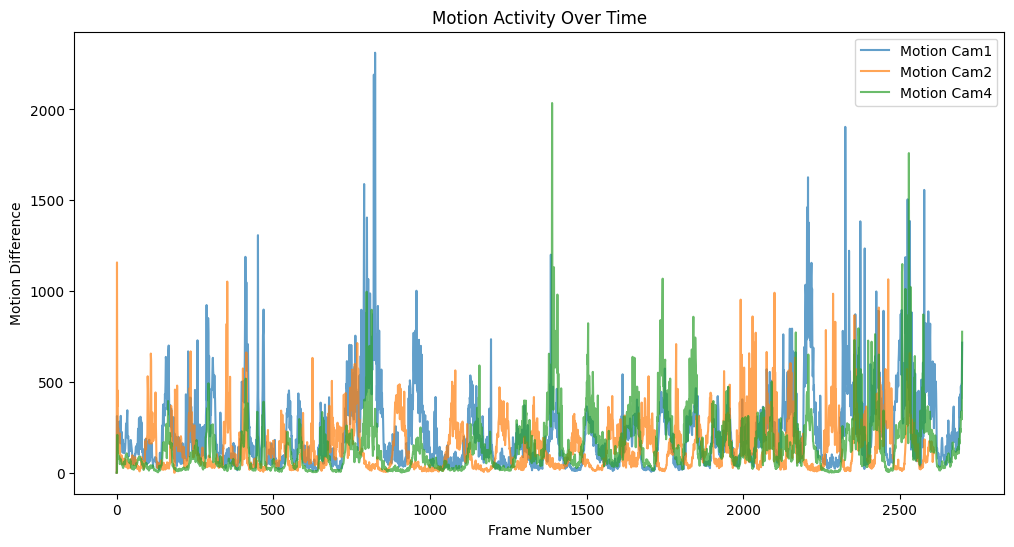

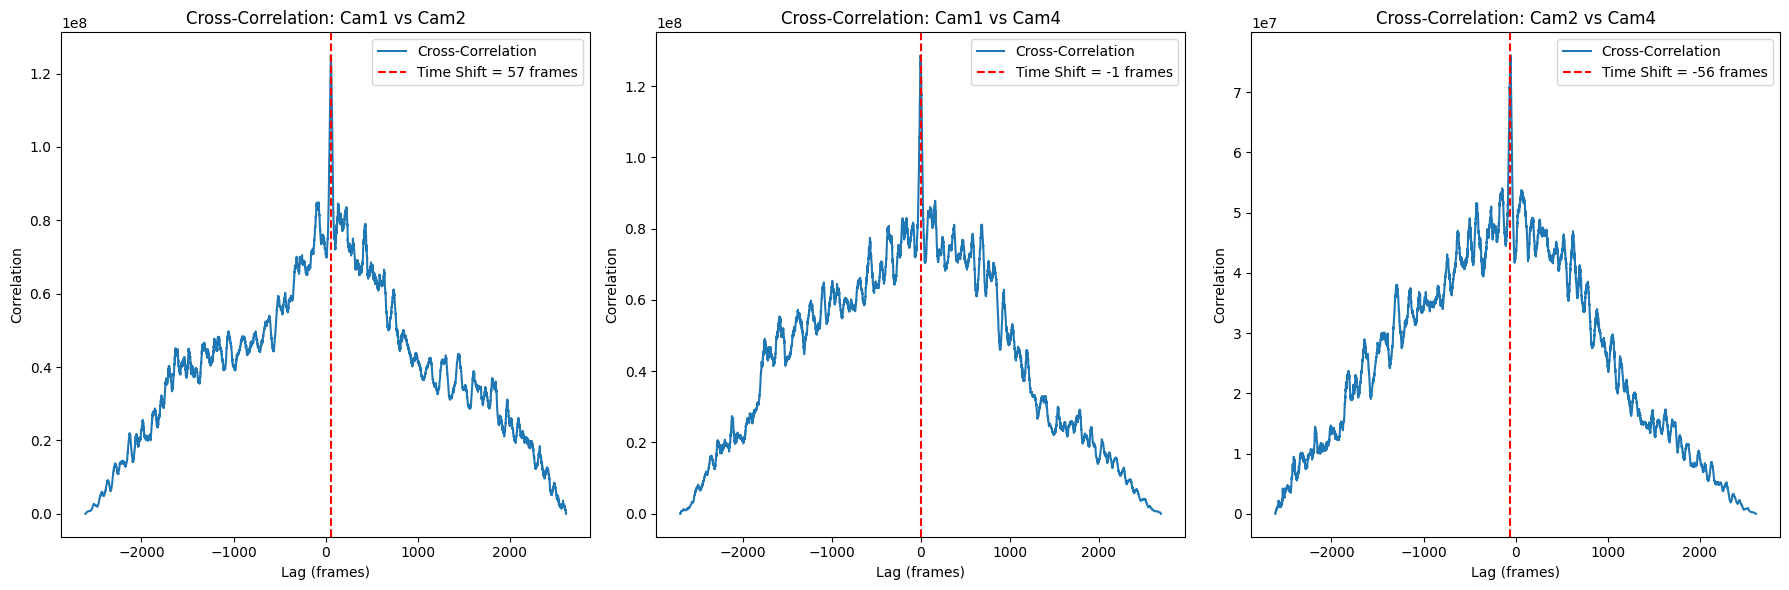

In [ ]:
#@title Анализ частоты движения и определения сдвига видео относительно друг друга
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Функция для вычисления изменений координат
def compute_motion_differences(df):
    motion_diffs = []
    for i in range(33):  # 33 ключевых точки Mediapipe Pose
        x_col = f'x_{i}'
        y_col = f'y_{i}'
        z_col = f'z_{i}'

        # Вычисляем разницу между последовательными кадрами
        dx = df[x_col].diff().fillna(0)
        dy = df[y_col].diff().fillna(0)
        dz = df[z_col].diff().fillna(0)

        # Суммарное изменение координат
        motion_diff = np.sqrt(dx**2 + dy**2 + dz**2)
        motion_diffs.append(motion_diff)

    # Общая активность движения как сумма по всем точкам
    total_motion = sum(motion_diffs)
    return total_motion

# Функция для нахождения временного сдвига
def find_time_shift(motion_1, motion_2):
    # Обрезаем более длинный ряд до длины более короткого
    min_length = min(len(motion_1), len(motion_2))
    motion_1 = motion_1[:min_length]
    motion_2 = motion_2[:min_length]

    # Вычисляем перекрестную корреляцию
    correlation = correlate(motion_1, motion_2, mode='full')
    lags = np.arange(-len(motion_1) + 1, len(motion_1))

    # Находим лаг с максимальной корреляцией
    max_corr_index = np.argmax(correlation)
    time_shift = lags[max_corr_index]
    return time_shift, correlation, lags

# Вычисление изменений координат для всех трех камер
motion_cam1 = compute_motion_differences(df1)
motion_cam2 = compute_motion_differences(df2)
motion_cam4 = compute_motion_differences(df4)

# Нахождение временных сдвигов между парами камер
time_shift_1_2, correlation_1_2, lags_1_2 = find_time_shift(motion_cam1, motion_cam2)
time_shift_1_4, correlation_1_4, lags_1_4 = find_time_shift(motion_cam1, motion_cam4)
time_shift_2_4, correlation_2_4, lags_2_4 = find_time_shift(motion_cam2, motion_cam4)

# Интерпретация результатов
print("Сравнение cam1 и cam2:")
if time_shift_1_2 > 0:
    print(f"Видео cam2 опережает cam1 на {time_shift_1_2} кадров.")
elif time_shift_1_2 < 0:
    print(f"Видео cam1 опережает cam2 на {-time_shift_1_2} кадров.")
else:
    print("Видео cam1 и cam2 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam1 и cam4:")
if time_shift_1_4 > 0:
    print(f"Видео cam4 опережает cam1 на {time_shift_1_4} кадров.")
elif time_shift_1_4 < 0:
    print(f"Видео cam1 опережает cam4 на {-time_shift_1_4} кадров.")
else:
    print("Видео cam1 и cam4 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam2 и cam4:")
if time_shift_2_4 > 0:
    print(f"Видео cam4 опережает cam2 на {time_shift_2_4} кадров.")
elif time_shift_2_4 < 0:
    print(f"Видео cam2 опережает cam4 на {-time_shift_2_4} кадров.")
else:
    print("Видео cam2 и cam4 синхронизированы (временной сдвиг равен 0).")

# Визуализация частоты движения для всех трех камер
plt.figure(figsize=(12, 6))
plt.plot(motion_cam1, label='Motion Cam1', alpha=0.7)
plt.plot(motion_cam2, label='Motion Cam2', alpha=0.7)
plt.plot(motion_cam4, label='Motion Cam4', alpha=0.7)
plt.title('Motion Activity Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Motion Difference')
plt.legend()
plt.show()

# Визуализация перекрестной корреляции для каждой пары камер
plt.figure(figsize=(18, 6))

# Cam1 vs Cam2
plt.subplot(1, 3, 1)
plt.plot(lags_1_2, correlation_1_2, label='Cross-Correlation')
plt.axvline(x=time_shift_1_2, color='red', linestyle='--', label=f'Time Shift = {time_shift_1_2} frames')
plt.title('Cross-Correlation: Cam1 vs Cam2')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam1 vs Cam4
plt.subplot(1, 3, 2)
plt.plot(lags_1_4, correlation_1_4, label='Cross-Correlation')
plt.axvline(x=time_shift_1_4, color='red', linestyle='--', label=f'Time Shift = {time_shift_1_4} frames')
plt.title('Cross-Correlation: Cam1 vs Cam4')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam2 vs Cam4
plt.subplot(1, 3, 3)
plt.plot(lags_2_4, correlation_2_4, label='Cross-Correlation')
plt.axvline(x=time_shift_2_4, color='red', linestyle='--', label=f'Time Shift = {time_shift_2_4} frames')
plt.title('Cross-Correlation: Cam2 vs Cam4')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print (time_shift_1_2, time_shift_1_4)

57 0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider  # Добавляем IntSlider

In [ ]:
# Список пар точек для соединения (например, для скелета MediaPipe)
connections = [
    # Лицо и шея
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

In [ ]:
#@title Отрисовываем скелет
def plot_frame(frame_index, offset_cam2, offset_cam4):
    # Получаем данные для выбранного кадра по порядку
    frame_data1 = df1.iloc[frame_index]

    # Применяем сдвиги для второй и третьей камер
    shifted_frame_index_cam2 = frame_index + offset_cam2
    shifted_frame_index_cam4 = frame_index + offset_cam4

    # Проверка границ для cam2
    if shifted_frame_index_cam2 < 0 or shifted_frame_index_cam2 >= len(df2):
        print(f"Сдвинутый кадр {shifted_frame_index_cam2} выходит за пределы данных второй камеры.")
        return

    # Проверка границ для cam4
    if shifted_frame_index_cam4 < 0 or shifted_frame_index_cam4 >= len(df4):
        print(f"Сдвинутый кадр {shifted_frame_index_cam4} выходит за пределы данных третьей камеры.")
        return

    frame_data2 = df2.iloc[shifted_frame_index_cam2]
    frame_data4 = df4.iloc[shifted_frame_index_cam4]

    # Извлечение координат x и y для всех точек
    def extract_coordinates(frame_data):
        x_coords = []
        y_coords = []
        for col in frame_data.index:
            if col.startswith("x_"):
                x_coords.append(frame_data[col])
            elif col.startswith("y_"):
                y_coords.append(frame_data[col])
        return x_coords, y_coords

    x1, y1 = extract_coordinates(frame_data1)
    x2, y2 = extract_coordinates(frame_data2)
    x4, y4 = extract_coordinates(frame_data4)

    # Определяем максимальные значения по осям X и Y
    max_x = max(max(x1), max(x2), max(x4))
    max_y = max(max(y1), max(y2), max(y4))

    # Создаем фигуру с тремя подграфиками
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # График для cam1
    axes[0].scatter(x1, y1, c='blue', label='cam1')
    axes[0].set_title(f"Camera 1 - Frame Index {frame_index}")
    axes[0].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[0].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[0].grid(True)  # Добавляем сетку
    axes[0].legend()

    # График для cam2
    axes[1].scatter(x2, y2, c='red', label='cam2')
    axes[1].set_title(f"Camera 2 - Frame Index {shifted_frame_index_cam2} (Offset: {offset_cam2})")
    axes[1].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[1].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[1].grid(True)  # Добавляем сетку
    axes[1].legend()

    # График для cam4
    axes[2].scatter(x4, y4, c='green', label='cam4')
    axes[2].set_title(f"Camera 4 - Frame Index {shifted_frame_index_cam4} (Offset: {offset_cam4})")
    axes[2].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[2].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[2].grid(True)  # Добавляем сетку
    axes[2].legend()

    # Функция для рисования связей
    def draw_connections(ax, x_coords, y_coords, connections):
        for start, end in connections:
            if start < len(x_coords) and end < len(x_coords):  # Проверяем, что индексы существуют
                ax.plot([x_coords[start], x_coords[end]], [y_coords[start], y_coords[end]], c='orange')

    # Добавляем связи на графики
    draw_connections(axes[0], x1, y1, connections)
    draw_connections(axes[1], x2, y2, connections)
    draw_connections(axes[2], x4, y4, connections)

    # Отображение графиков
    plt.tight_layout()
    plt.show()

In [ ]:
# Создаем слайдер для выбора кадра
max_frame_index = min(len(df1), len(df2), len(df4)) - 1  # Максимальный индекс кадра
frame_slider = IntSlider(min=0, max=max_frame_index, step=1, value=0, description="Frame Index")

# Создаем слайдеры для выбора сдвига для cam2 и cam4
offset_slider_cam2 = IntSlider(min=-max_frame_index, max=max_frame_index, step=1, value=0, description="Offset Cam2")
offset_slider_cam4 = IntSlider(min=-max_frame_index, max=max_frame_index, step=1, value=0, description="Offset Cam4")

# Привязываем функцию plot_frame к слайдерам
interact(plot_frame, frame_index=frame_slider, offset_cam2=offset_slider_cam2, offset_cam4=offset_slider_cam4)

interactive(children=(IntSlider(value=0, description='Frame Index', max=1319), IntSlider(value=0, description=…

<function __main__.plot_frame(frame_index, offset_cam2, offset_cam4)>

# Триангуляция

In [ ]:
# Функция для создания проекционной матрицы
def create_projection_matrix(camera_matrix, rotation_matrix, translation_vector):
    """
    Создает проекционную матрицу P = K[R|t].
    """
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix @ extrinsic_matrix
    return projection_matrix

def synchronize_data(df1, df2, df4, offset_cam2=0, offset_cam4=0):
    """
    Синхронизирует данные трех камер на основе временных сдвигов.
    """
    max_length = min(
        len(df1),
        len(df2) + abs(offset_cam2),
        len(df4) + abs(offset_cam4)
    )

    synchronized_data = {
        'cam1': df1.iloc[:max_length],
        'cam2': df2.iloc[offset_cam2:offset_cam2 + max_length] if offset_cam2 >= 0 else df2.iloc[:len(df2) + offset_cam2],
        'cam4': df4.iloc[offset_cam4:offset_cam4 + max_length] if offset_cam4 >= 0 else df4.iloc[:len(df4) + offset_cam4],
    }
    return synchronized_data

# Взвешенная триангуляция (из triangulation.txt)
def weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files):
    """
    Выполняет взвешенную триангуляцию для получения начальных 3D-координат.
    """
    A = []
    for i in range(len(projection_matrices)):
        P = projection_matrices[i]
        x, y = x_files[i], y_files[i]
        w = likelihood_files[i]  # Вес (достоверность)

        if np.isnan(x) or np.isnan(y) or np.isnan(w) or w == 0:
            continue  # Пропускаем камеры с недоступными данными

        # Уравнения для триангуляции
        A.append(w * (x * P[2] - P[0]))
        A.append(w * (y * P[2] - P[1]))

    if len(A) < 4:
        return np.array([np.nan, np.nan, np.nan, np.nan])  # Недостаточно данных для триангуляции

    A = np.array(A)

    # Решение системы уравнений методом SVD
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]  # Последняя строка Vt содержит решение

    # Нормализация однородных координат
    X = X / X[3]

    return X

# Триангуляция для каждой ключевой точки
num_keypoints = 33  # Количество ключевых точек Mediapipe Pose
frames_3d = []

# Синхронизация данных
synchronized_data = synchronize_data(df1, df2, df4, time_shift_1_2, time_shift_1_4)

# Проекционные матрицы
proj_mat1 = create_projection_matrix(intrinsics['cam1']['camera_matrix'], extrinsics['cam1']['rotation_matrix'], extrinsics['cam1']['translation_vector'])
proj_mat2 = create_projection_matrix(intrinsics['cam2']['camera_matrix'], extrinsics['cam2']['rotation_matrix'], extrinsics['cam2']['translation_vector'])
proj_mat4 = create_projection_matrix(intrinsics['cam4']['camera_matrix'], extrinsics['cam4']['rotation_matrix'], extrinsics['cam4']['translation_vector'])

projection_matrices = [proj_mat1, proj_mat2, proj_mat4]

print("Проекционые матрицы")
print(projection_matrices)

# Определение минимальной длины данных
min_length = min(
    len(synchronized_data['cam1']),
    len(synchronized_data['cam2']),
    len(synchronized_data['cam4'])
)


# Обработка только тех кадров, которые доступны для всех камер
for frame_index in range(min_length):
    frame_3d = []
    for keypoint_index in range(num_keypoints):
        # Извлечение координат точки для всех камер
        # Извлечение координат и достоверности
        try:
            x1 = synchronized_data['cam1'].iloc[frame_index][f'x_{keypoint_index}']
            y1 = synchronized_data['cam1'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood1 = synchronized_data['cam1'].iloc[frame_index][f'visibility_{keypoint_index}']

            x2 = synchronized_data['cam2'].iloc[frame_index][f'x_{keypoint_index}']
            y2 = synchronized_data['cam2'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood2 = synchronized_data['cam2'].iloc[frame_index][f'visibility_{keypoint_index}']

            x4 = synchronized_data['cam4'].iloc[frame_index][f'x_{keypoint_index}']
            y4 = synchronized_data['cam4'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood4 = synchronized_data['cam4'].iloc[frame_index][f'visibility_{keypoint_index}']
        except IndexError:
            print(f"Frame index {frame_index} is out of bounds for one of the cameras.")
            continue  # Пропустить текущий кадр

        # Координаты и достоверности
        x_files = [x1, x2, x4]
        y_files = [y1, y2, y4]
        likelihood_files = [likelihood1, likelihood2, likelihood4]

        # Взвешенная триангуляция
        point_3d = weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files)
        frame_3d.append(point_3d[:3])  # Берем только первые три координаты (X, Y, Z)

    frames_3d.append(frame_3d)

# Результат: список 3D-координат для каждого кадра
frames_3d = np.array(frames_3d)

Проекционые матрицы
[array([[ 2.73644060e+03, -7.13612775e+02, -2.16694225e+02,
         5.10346026e+03],
       [-3.15312473e+01, -2.89123320e+02, -2.52530780e+03,
         4.32408487e+03],
       [ 6.41999250e-01,  7.09565401e-01, -2.90437438e-01,
         5.57308522e+00]]), array([[ 1.49497363e+03,  2.27657402e+03, -3.23798971e+02,
         7.61219468e+03],
       [ 1.76512848e+02, -2.17606846e+02, -2.55099443e+03,
         5.45159797e+03],
       [-5.34775681e-01,  7.82686840e-01, -3.18459231e-01,
         9.60747452e+00]]), array([[-1.63547672e+03,  3.57482433e+01, -3.00020139e+02,
         4.93336997e+03],
       [-7.33669731e+01, -1.29626858e+02, -1.43212206e+03,
         2.81798235e+03],
       [-5.71788897e-01, -7.69555533e-01, -2.84326818e-01,
         4.63070041e+00]])]


In [ ]:
frames_3d

array([[[-3.43193383e-01, -5.02667413e-01,  1.61761102e+00],
        [-3.62195986e-01, -4.95934191e-01,  1.65786789e+00],
        [-3.72561287e-01, -4.85582586e-01,  1.65577786e+00],
        ...,
        [-2.56875890e-01, -8.37312129e-01, -6.02406691e-02],
        [-3.94855093e-01, -4.56458118e-01, -1.44765663e-01],
        [-6.76409457e-02, -7.17827994e-01,  4.19252445e-03]],

       [[-3.28261644e-01, -5.14301626e-01,  1.60033344e+00],
        [-3.48304722e-01, -5.07182320e-01,  1.63871528e+00],
        [-3.57819462e-01, -4.97982209e-01,  1.63831519e+00],
        ...,
        [-2.49930778e-01, -8.35674470e-01, -6.37541343e-02],
        [-4.17017822e-01, -4.60404175e-01, -1.37309743e-01],
        [-7.81992607e-02, -6.82726989e-01, -3.05974356e-02]],

       [[-3.23468929e-01, -5.14963025e-01,  1.59814878e+00],
        [-3.41726025e-01, -5.04621044e-01,  1.63702435e+00],
        [-3.52505395e-01, -4.99008033e-01,  1.63647000e+00],
        ...,
        [-2.57794295e-01, -8.45360472e-01,

In [ ]:
np.save('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy', frames_3d)

In [ ]:
import numpy as np
frames_3d = np.load('/content/drive/MyDrive/Karate_2/triang_3/frames_3d.npy')

## Визуализация 3D

interactive(children=(IntSlider(value=0, description='Frame Index', max=1262), Output()), _dom_classes=('widge…

<function __main__.plot_skeleton(frame_index)>

In [ ]:
#@title Создание видео движения скелета
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import gc  # Импортируем сборщик мусора

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для сохранения кадра
def save_frame(frame_index, frames_3d, output_dir):
    fig = plt.figure(figsize=(10, 5))  # Уменьшаем размер графика
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отображение точек
    x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=50)

    # Отображение связей между точками
    for start, end in connections:
        xs = [keypoints[start][0], keypoints[end][0]]
        ys = [keypoints[start][1], keypoints[end][1]]
        zs = [keypoints[start][2], keypoints[end][2]]
        ax.plot(xs, ys, zs, c='blue')

    # Настройка осей на основе данных
    ax.set_xlim(np.min(frames_3d[:, :, 0]), np.max(frames_3d[:, :, 0]))
    ax.set_ylim(np.min(frames_3d[:, :, 1]), np.max(frames_3d[:, :, 1]))
    ax.set_zlim(np.min(frames_3d[:, :, 2]), np.max(frames_3d[:, :, 2]))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Сохранение кадра
    frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
    plt.savefig(frame_path, format='jpg', dpi=75)  # Уменьшаем разрешение
    plt.close(fig)

    # Очистка памяти
    del fig, ax, keypoints, x, y, z
    gc.collect()

# Генерация кадров
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

num_frames = frames_3d.shape[0]  # Общее количество кадров
batch_size = 100  # Размер пакета для обработки

for batch_start in range(0, num_frames, batch_size):
    batch_end = min(batch_start + batch_size, num_frames)
    for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
        save_frame(frame_index, frames_3d, output_dir)
    gc.collect()  # Освобождаем память после обработки пакета

# Создание видео с помощью FFmpeg
subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "output.mp4"
])

print("Видео успешно создано: output.mp4")

Генерация кадров: 100%|██████████| 63/63 [04:33<00:00,  4.34s/frame]


Видео успешно создано: output.mp4


In [ ]:
#@title Создание комбинированного видео
import subprocess

# Пути к видео
video_pose_1 = '/content/drive/MyDrive/Karate_2/triang_3/videos_with_poses/cam1.mp4_with_poses.mp4'
video_pose_2 = '/content/drive/MyDrive/Karate_2/triang_3/videos_with_poses/cam2.mp4_with_poses.mp4'
video_pose_3 = '/content/drive/MyDrive/Karate_2/triang_3/output.mp4'
video_pose_4 = '/content/drive/MyDrive/Karate_2/triang_3/videos_with_poses/cam4.mp4_with_poses.mp4'

# Временные сдвиги в кадрах
time_shift_1_2_frames = 57  # Сдвиг между cam1 и cam2 (в кадрах)
time_shift_1_3_frames = 114
time_shift_1_4_frames = 1   # Сдвиг между cam1 и cam4 (в кадрах)

# Частота кадров (FPS)
fps = 30  # Замените на фактическую частоту кадров, если она отличается

# Преобразование сдвигов из кадров в секунды
time_shift_1_2 = time_shift_1_2_frames / fps
time_shift_1_3 = time_shift_1_3_frames / fps
time_shift_1_4 = time_shift_1_4_frames / fps

# Выходной файл
output_video = '/content/drive/MyDrive/Karate_2/triang_3/combined_video_2x2.mp4'

def get_video_resolution(video_path):
    """
    Получает разрешение видео (ширина и высота) с помощью ffprobe.
    """
    command = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=width,height",
        "-of", "csv=p=0",
        str(video_path)
    ]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    width, height = map(int, result.stdout.decode().strip().split(','))
    return width, height

# Определение целевого разрешения (например, разрешение первого видео)
target_width, target_height = get_video_resolution(video_pose_1)

# Команда FFmpeg с масштабированием video_pose_3
command = [
    "ffmpeg",
    "-y",  # Разрешаем перезапись выходного файла
    "-i", video_pose_1,  # Первое видео (cam1) без сдвига
    "-itsoffset", str(time_shift_1_2), "-i", video_pose_2,  # Второе видео (cam2) со сдвигом
    "-itsoffset", str(time_shift_1_3), "-i", video_pose_3,  # Третье видео (output.mp4) со сдвигом
    "-itsoffset", str(time_shift_1_4), "-i", video_pose_4,  # Четвертое видео (cam4) со сдвигом
    "-filter_complex",
    f"[2:v]scale={target_width}:{target_height}[scaled_v3];"  # Масштабирование video_pose_3
    "[0:v][1:v][scaled_v3][3:v]xstack=inputs=4:layout=0_0|w0_0|0_h0|w0_h0[outv]",  # Комбинирование в сетку 2x2
    "-map", "[outv]",
    output_video
]

# Запуск команды
subprocess.run(command, check=True)

print(f"Комбинированное видео сохранено в {output_video}")

Комбинированное видео сохранено в /content/drive/MyDrive/Karate_2/triang_3/combined_video_2x2.mp4


In [ ]:
#@title Сравнение движения по сцене

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/calibrate_1+2+4/frames_3d.npy')
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/triang_3/frames_3d.npy')

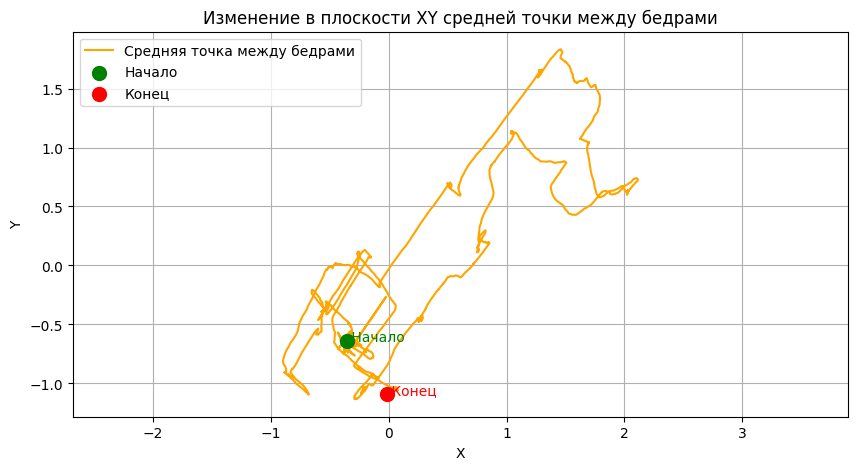

In [ ]:
# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров
mid_point_x = (frames_3d_1[:, 23, 0] + frames_3d_1[:, 24, 0]) / 2
mid_point_y = (frames_3d_1[:, 23, 1] + frames_3d_1[:, 24, 1]) / 2

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(mid_point_x, mid_point_y, label="Средняя точка между бедрами", color="orange")

# Добавление точки начала
plt.scatter(mid_point_x[0], mid_point_y[0], color="green", s=100, label="Начало", zorder=5)
plt.text(mid_point_x[0], mid_point_y[0], " Начало", color="green", fontsize=10)

# Добавление точки конца
plt.scatter(mid_point_x[-1], mid_point_y[-1], color="red", s=100, label="Конец", zorder=5)
plt.text(mid_point_x[-1], mid_point_y[-1], " Конец", color="red", fontsize=10)

# Настройка графика
plt.title("Изменение в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей
plt.show()

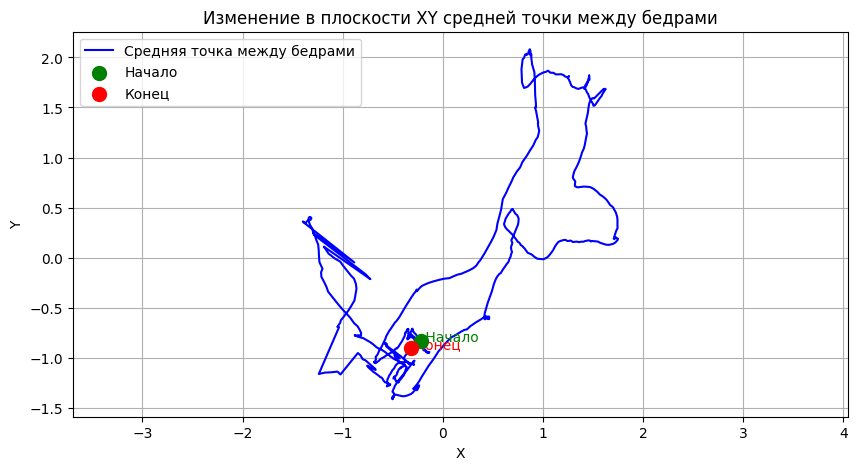

In [ ]:
# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров
mid_point_x = (frames_3d_2[:, 23, 0] + frames_3d_2[:, 24, 0]) / 2
mid_point_y = (frames_3d_2[:, 23, 1] + frames_3d_2[:, 24, 1]) / 2

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(mid_point_x, mid_point_y, label="Средняя точка между бедрами", color="blue")

# Добавление точки начала
plt.scatter(mid_point_x[0], mid_point_y[0], color="green", s=100, label="Начало", zorder=5)
plt.text(mid_point_x[0], mid_point_y[0], " Начало", color="green", fontsize=10)

# Добавление точки конца
plt.scatter(mid_point_x[-1], mid_point_y[-1], color="red", s=100, label="Конец", zorder=5)
plt.text(mid_point_x[-1], mid_point_y[-1], " Конец", color="red", fontsize=10)

# Настройка графика
plt.title("Изменение в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей
plt.show()

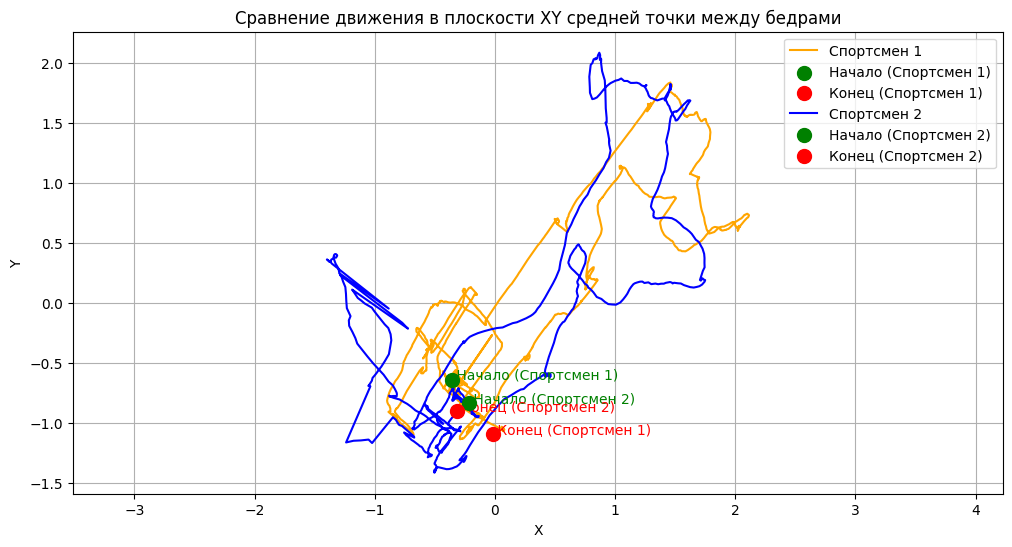

In [ ]:
# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 1)
mid_point_x_1 = (frames_3d_1[:, 23, 0] + frames_3d_1[:, 24, 0]) / 2
mid_point_y_1 = (frames_3d_1[:, 23, 1] + frames_3d_1[:, 24, 1]) / 2

# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 2)
mid_point_x_2 = (frames_3d_2[:, 23, 0] + frames_3d_2[:, 24, 0]) / 2
mid_point_y_2 = (frames_3d_2[:, 23, 1] + frames_3d_2[:, 24, 1]) / 2

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(mid_point_x_1, mid_point_y_1, label="Спортсмен 1", color="orange")
plt.scatter(mid_point_x_1[0], mid_point_y_1[0], color="green", s=100, label="Начало (Спортсмен 1)", zorder=5)
plt.text(mid_point_x_1[0], mid_point_y_1[0], " Начало (Спортсмен 1)", color="green", fontsize=10)
plt.scatter(mid_point_x_1[-1], mid_point_y_1[-1], color="red", s=100, label="Конец (Спортсмен 1)", zorder=5)
plt.text(mid_point_x_1[-1], mid_point_y_1[-1], " Конец (Спортсмен 1)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(mid_point_x_2, mid_point_y_2, label="Спортсмен 2", color="blue")
plt.scatter(mid_point_x_2[0], mid_point_y_2[0], color="green", s=100, label="Начало (Спортсмен 2)", zorder=5)
plt.text(mid_point_x_2[0], mid_point_y_2[0], " Начало (Спортсмен 2)", color="green", fontsize=10)
plt.scatter(mid_point_x_2[-1], mid_point_y_2[-1], color="red", s=100, label="Конец (Спортсмен 2)", zorder=5)
plt.text(mid_point_x_2[-1], mid_point_y_2[-1], " Конец (Спортсмен 2)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

'''
# Добавление метрики расстояния между средними точками бедер
distances = np.sqrt((mid_point_x_1 - mid_point_x_2)**2 + (mid_point_y_1 - mid_point_y_2)**2)
mean_distance = np.mean(distances)
max_distance = np.max(distances)
min_distance = np.min(distances)

plt.text(0.05, 0.95, f"Среднее расстояние: {mean_distance:.2f}\nМаксимальное расстояние: {max_distance:.2f}\nМинимальное расстояние: {min_distance:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
'''
plt.show()

In [ ]:
#@title Вывод калибровочной конфигурации
import os
import cv2
# Функция для загрузки калибровочных данных
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("distortion_coefficients").mat()
    fs.release()
    return camera_matrix, dist_coeffs

def load_extrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam}_extrinsics.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внешних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    rotation_matrix = fs.getNode("rotation_matrix").mat()
    translation_vector = fs.getNode("translation_vector").mat()
    fs.release()
    return rotation_matrix, translation_vector

# Загрузка калибровочных данных
calib_dir = '/content/drive/MyDrive/Karate_2/triang_3'
cams = ['cam1', 'cam2', 'cam4']

intrinsics = {}
extrinsics = {}

for cam in cams:
    camera_matrix, dist_coeffs = load_intrinsics_opencv(calib_dir, cam)
    rotation_matrix, translation_vector = load_extrinsics_opencv(calib_dir, cam)
    intrinsics[cam] = {'camera_matrix': camera_matrix, 'dist_coeffs': dist_coeffs}
    extrinsics[cam] = {'rotation_matrix': rotation_matrix, 'translation_vector': translation_vector}

In [ ]:
intrinsics

{'cam1': {'camera_matrix': array([[2.51383283e+03, 0.00000000e+00, 1.31337399e+03],
         [0.00000000e+00, 2.49071320e+03, 5.08048986e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[ 4.78934978e-01,  5.76955632e+00, -5.87764053e-03,
           4.05717282e-02, -7.84471007e+01]])},
 'cam2': {'camera_matrix': array([[2.51878976e+03, 0.00000000e+00, 1.08548575e+03],
         [0.00000000e+00, 2.50721644e+03, 5.47674933e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[ 2.13204690e-01, -3.80116441e-01,  3.11225881e-04,
           4.71316699e-03, -2.39162019e+00]])},
 'cam4': {'camera_matrix': array([[1.33421977e+03, 0.00000000e+00, 9.92940940e+02],
         [0.00000000e+00, 1.33111698e+03, 5.48896195e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[-2.94448256e-02,  8.96096431e-01,  1.07542936e-03,
          -3.36732650e-03, -2.85529189e+00]])}}

In [ ]:
extrinsics

{'cam1': {'rotation_matrix': array([[ 0.753135  , -0.65459306,  0.06554086],
         [-0.14361281, -0.26081578, -0.95464679],
         [ 0.64199925,  0.7095654 , -0.29043744]]),
  'translation_vector': array([[-0.88155621],
         [ 0.59930006],
         [ 5.57308522]])},
 'cam2': {'rotation_matrix': array([[ 0.82399295,  0.56653343,  0.00868829],
         [ 0.18721801, -0.25776187, -0.94789674],
         [-0.53477568,  0.78268684, -0.31845923]]),
  'translation_vector': array([[-1.11822831],
         [ 0.07571146],
         [ 9.60747452]])},
 'cam4': {'rotation_matrix': array([[-0.80026105,  0.59950501, -0.01326648],
         [ 0.18066465,  0.21995005, -0.95863562],
         [-0.5717889 , -0.76955553, -0.28432682]]),
  'translation_vector': array([[0.25135136],
         [0.20750131],
         [4.63070041]])}}

In [ ]:
#@title Корректировка дисторсии

import numpy as np
import cv2  # Для коррекции дисторсии

# Функция для создания проекционной матрицы
def create_projection_matrix(camera_matrix, rotation_matrix, translation_vector):
    """
    Создает проекционную матрицу P = K[R|t].
    """
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix @ extrinsic_matrix
    return projection_matrix

def undistort_points(x, y, camera_matrix, dist_coeffs):
    """
    Корректирует дисторсию для заданных координат точки.
    """
    points = np.array([[x, y]], dtype=np.float32).reshape(-1, 1, 2)
    undistorted_points = cv2.undistortPoints(points, camera_matrix, dist_coeffs, None, camera_matrix)
    return undistorted_points[0][0]  # Возвращаем скорректированные координаты (x', y')

def synchronize_data(df1, df2, df4, offset_cam2=0, offset_cam4=0):
    """
    Синхронизирует данные трех камер на основе временных сдвигов.
    """
    max_length = min(
        len(df1),
        len(df2) + abs(offset_cam2),
        len(df4) + abs(offset_cam4)
    )

    synchronized_data = {
        'cam1': df1.iloc[:max_length],
        'cam2': df2.iloc[offset_cam2:offset_cam2 + max_length] if offset_cam2 >= 0 else df2.iloc[:len(df2) + offset_cam2],
        'cam4': df4.iloc[offset_cam4:offset_cam4 + max_length] if offset_cam4 >= 0 else df4.iloc[:len(df4) + offset_cam4],
    }
    return synchronized_data

# Взвешенная триангуляция (из triangulation.txt)
def weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files):
    """
    Выполняет взвешенную триангуляцию для получения начальных 3D-координат.
    """
    A = []
    for i in range(len(projection_matrices)):
        P = projection_matrices[i]
        x, y = x_files[i], y_files[i]
        w = likelihood_files[i]  # Вес (достоверность)

        if np.isnan(x) or np.isnan(y) or np.isnan(w) or w == 0:
            continue  # Пропускаем камеры с недоступными данными

        # Уравнения для триангуляции
        A.append(w * (x * P[2] - P[0]))
        A.append(w * (y * P[2] - P[1]))

    if len(A) < 4:
        return np.array([np.nan, np.nan, np.nan, np.nan])  # Недостаточно данных для триангуляции

    A = np.array(A)

    # Решение системы уравнений методом SVD
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]  # Последняя строка Vt содержит решение

    # Нормализация однородных координат
    X = X / X[3]

    return X

# Триангуляция для каждой ключевой точки
num_keypoints = 33  # Количество ключевых точек Mediapipe Pose
frames_3d = []

# Синхронизация данных
synchronized_data = synchronize_data(df1, df2, df4, time_shift_1_2, time_shift_1_4)

# Проекционные матрицы
proj_mat1 = create_projection_matrix(intrinsics['cam1']['camera_matrix'], extrinsics['cam1']['rotation_matrix'], extrinsics['cam1']['translation_vector'])
proj_mat2 = create_projection_matrix(intrinsics['cam2']['camera_matrix'], extrinsics['cam2']['rotation_matrix'], extrinsics['cam2']['translation_vector'])
proj_mat4 = create_projection_matrix(intrinsics['cam4']['camera_matrix'], extrinsics['cam4']['rotation_matrix'], extrinsics['cam4']['translation_vector'])

projection_matrices = [proj_mat1, proj_mat2, proj_mat4]

print("Проекционные матрицы")
print(projection_matrices)

# Определение минимальной длины данных
min_length = min(
    len(synchronized_data['cam1']),
    len(synchronized_data['cam2']),
    len(synchronized_data['cam4'])
)

# Параметры дисторсии для каждой камеры
dist_coeffs1 = intrinsics['cam1']['dist_coeffs']
dist_coeffs2 = intrinsics['cam2']['dist_coeffs']
dist_coeffs4 = intrinsics['cam4']['dist_coeffs']

# Обработка только тех кадров, которые доступны для всех камер
for frame_index in range(min_length):
    frame_3d = []
    for keypoint_index in range(num_keypoints):
        # Извлечение координат точки для всех камер
        try:
            x1 = synchronized_data['cam1'].iloc[frame_index][f'x_{keypoint_index}']
            y1 = synchronized_data['cam1'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood1 = synchronized_data['cam1'].iloc[frame_index][f'visibility_{keypoint_index}']

            x2 = synchronized_data['cam2'].iloc[frame_index][f'x_{keypoint_index}']
            y2 = synchronized_data['cam2'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood2 = synchronized_data['cam2'].iloc[frame_index][f'visibility_{keypoint_index}']

            x4 = synchronized_data['cam4'].iloc[frame_index][f'x_{keypoint_index}']
            y4 = synchronized_data['cam4'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood4 = synchronized_data['cam4'].iloc[frame_index][f'visibility_{keypoint_index}']
        except IndexError:
            print(f"Frame index {frame_index} is out of bounds for one of the cameras.")
            continue  # Пропустить текущий кадр

        # Корректировка дисторсии
        camera_matrix1 = intrinsics['cam1']['camera_matrix']
        camera_matrix2 = intrinsics['cam2']['camera_matrix']
        camera_matrix4 = intrinsics['cam4']['camera_matrix']

        x1, y1 = undistort_points(x1, y1, camera_matrix1, dist_coeffs1)
        x2, y2 = undistort_points(x2, y2, camera_matrix2, dist_coeffs2)
        x4, y4 = undistort_points(x4, y4, camera_matrix4, dist_coeffs4)

        # Координаты и достоверности
        x_files = [x1, x2, x4]
        y_files = [y1, y2, y4]
        likelihood_files = [likelihood1, likelihood2, likelihood4]

        # Взвешенная триангуляция
        point_3d = weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files)
        frame_3d.append(point_3d[:3])  # Берем только первые три координаты (X, Y, Z)

    frames_3d.append(frame_3d)

# Результат: список 3D-координат для каждого кадра
frames_3d = np.array(frames_3d)

Проекционные матрицы
[array([[ 2.73644060e+03, -7.13612775e+02, -2.16694225e+02,
         5.10346026e+03],
       [-3.15312473e+01, -2.89123320e+02, -2.52530780e+03,
         4.32408487e+03],
       [ 6.41999250e-01,  7.09565401e-01, -2.90437438e-01,
         5.57308522e+00]]), array([[ 1.49497363e+03,  2.27657402e+03, -3.23798971e+02,
         7.61219468e+03],
       [ 1.76512848e+02, -2.17606846e+02, -2.55099443e+03,
         5.45159797e+03],
       [-5.34775681e-01,  7.82686840e-01, -3.18459231e-01,
         9.60747452e+00]]), array([[-1.63547672e+03,  3.57482433e+01, -3.00020139e+02,
         4.93336997e+03],
       [-7.33669731e+01, -1.29626858e+02, -1.43212206e+03,
         2.81798235e+03],
       [-5.71788897e-01, -7.69555533e-01, -2.84326818e-01,
         4.63070041e+00]])]


In [ ]:
frames_3d

array([[[-0.33399778, -0.49616337,  1.60143186],
        [-0.35255293, -0.48929828,  1.640394  ],
        [-0.3628357 , -0.47900377,  1.63829086],
        ...,
        [-0.25040538, -0.82772929, -0.05413502],
        [-0.38755894, -0.44973429, -0.13683145],
        [-0.06479471, -0.71157238,  0.00589509]],

       [[-0.31958403, -0.50726404,  1.58601336],
        [-0.33916039, -0.49993191,  1.62320468],
        [-0.3485903 , -0.49077194,  1.62278479],
        ...,
        [-0.24332987, -0.82587805, -0.05815299],
        [-0.40930109, -0.4521276 , -0.13074406],
        [-0.07498608, -0.67701876, -0.02870655]],

       [[-0.3148574 , -0.50796774,  1.58387264],
        [-0.33267573, -0.4974657 ,  1.62159466],
        [-0.34335024, -0.49184526,  1.6209943 ],
        ...,
        [-0.25112742, -0.83551442, -0.0476534 ],
        [-0.42964076, -0.47780348, -0.1057904 ],
        [-0.08494526, -0.70779388, -0.01097561]],

       ...,

       [[ 0.373728  , -0.85874483,  1.47233266],
        [ 0

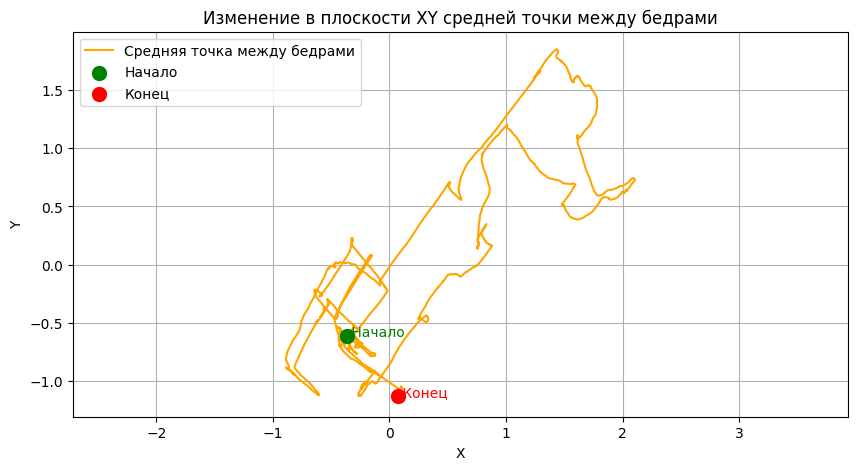

In [ ]:
# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров
mid_point_x = (frames_3d[:, 23, 0] + frames_3d[:, 24, 0]) / 2
mid_point_y = (frames_3d[:, 23, 1] + frames_3d[:, 24, 1]) / 2

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(mid_point_x, mid_point_y, label="Средняя точка между бедрами", color="orange")

# Добавление точки начала
plt.scatter(mid_point_x[0], mid_point_y[0], color="green", s=100, label="Начало", zorder=5)
plt.text(mid_point_x[0], mid_point_y[0], " Начало", color="green", fontsize=10)

# Добавление точки конца
plt.scatter(mid_point_x[-1], mid_point_y[-1], color="red", s=100, label="Конец", zorder=5)
plt.text(mid_point_x[-1], mid_point_y[-1], " Конец", color="red", fontsize=10)

# Настройка графика
plt.title("Изменение в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/calibrate_1+2+4/frames_3d.npy')
frames_3d_2 = frames_3d

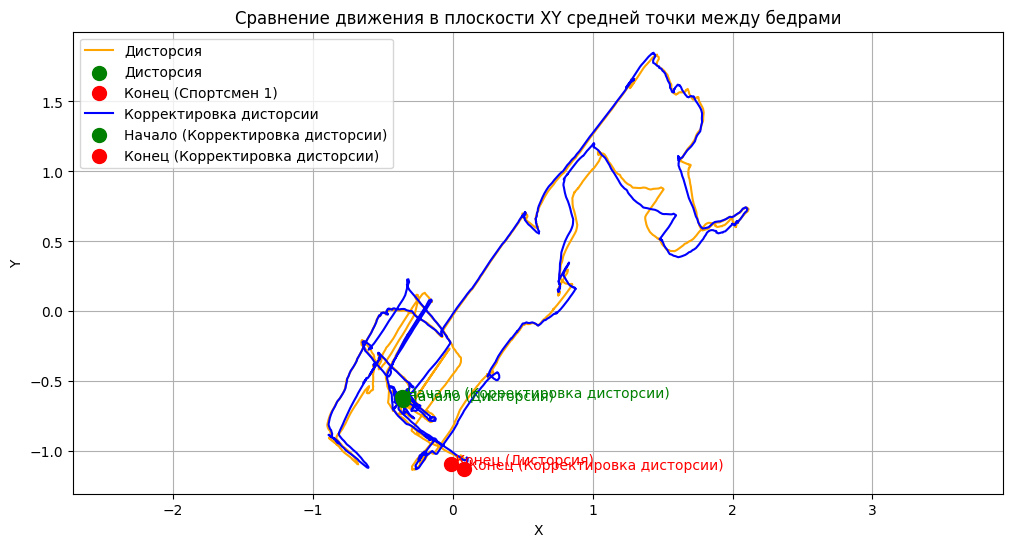

In [ ]:
# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 1)
mid_point_x_1 = (frames_3d_1[:, 23, 0] + frames_3d_1[:, 24, 0]) / 2
mid_point_y_1 = (frames_3d_1[:, 23, 1] + frames_3d_1[:, 24, 1]) / 2

# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 2)
mid_point_x_2 = (frames_3d_2[:, 23, 0] + frames_3d_2[:, 24, 0]) / 2
mid_point_y_2 = (frames_3d_2[:, 23, 1] + frames_3d_2[:, 24, 1]) / 2

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(mid_point_x_1, mid_point_y_1, label="Дисторсия", color="orange")
plt.scatter(mid_point_x_1[0], mid_point_y_1[0], color="green", s=100, label="Дисторсия", zorder=5)
plt.text(mid_point_x_1[0], mid_point_y_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(mid_point_x_1[-1], mid_point_y_1[-1], color="red", s=100, label="Конец (Спортсмен 1)", zorder=5)
plt.text(mid_point_x_1[-1], mid_point_y_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(mid_point_x_2, mid_point_y_2, label="Корректировка дисторсии", color="blue")
plt.scatter(mid_point_x_2[0], mid_point_y_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[0], mid_point_y_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(mid_point_x_2[-1], mid_point_y_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[-1], mid_point_y_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

'''
# Добавление метрики расстояния между средними точками бедер
distances = np.sqrt((mid_point_x_1 - mid_point_x_2)**2 + (mid_point_y_1 - mid_point_y_2)**2)
mean_distance = np.mean(distances)
max_distance = np.max(distances)
min_distance = np.min(distances)

plt.text(0.05, 0.95, f"Среднее расстояние: {mean_distance:.2f}\nМаксимальное расстояние: {max_distance:.2f}\nМинимальное расстояние: {min_distance:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
'''
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')

<Figure size 640x480 with 0 Axes>

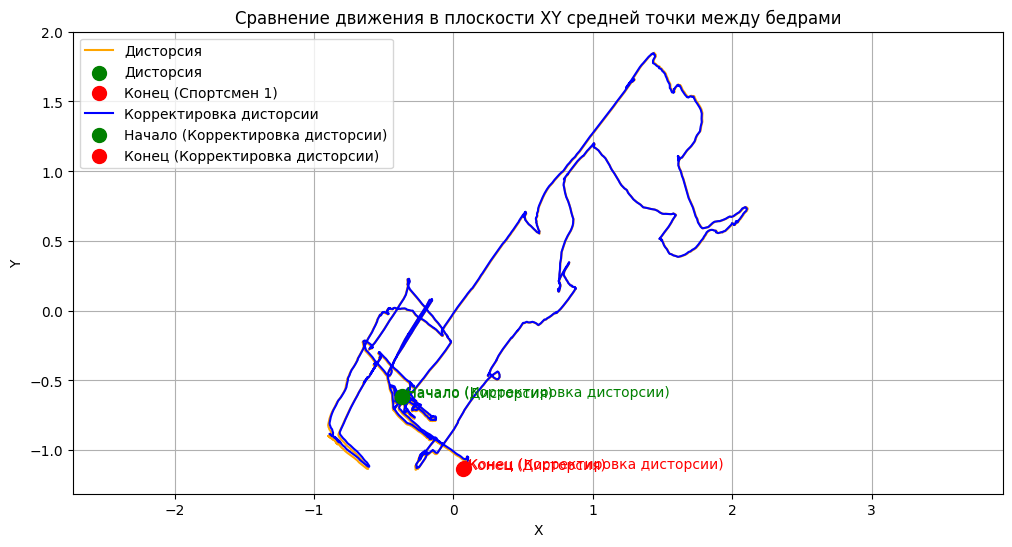

In [ ]:
# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 1)
mid_point_x_1 = (frames_3d_1[:, 23, 0] + frames_3d_1[:, 24, 0]) / 2
mid_point_y_1 = (frames_3d_1[:, 23, 1] + frames_3d_1[:, 24, 1]) / 2

# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 2)
mid_point_x_2 = (frames_3d_2[:, 23, 0] + frames_3d_2[:, 24, 0]) / 2
mid_point_y_2 = (frames_3d_2[:, 23, 1] + frames_3d_2[:, 24, 1]) / 2

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(mid_point_x_1, mid_point_y_1, label="Дисторсия", color="orange")
plt.scatter(mid_point_x_1[0], mid_point_y_1[0], color="green", s=100, label="Дисторсия", zorder=5)
plt.text(mid_point_x_1[0], mid_point_y_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(mid_point_x_1[-1], mid_point_y_1[-1], color="red", s=100, label="Конец (Спортсмен 1)", zorder=5)
plt.text(mid_point_x_1[-1], mid_point_y_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(mid_point_x_2, mid_point_y_2, label="Корректировка дисторсии", color="blue")
plt.scatter(mid_point_x_2[0], mid_point_y_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[0], mid_point_y_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(mid_point_x_2[-1], mid_point_y_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[-1], mid_point_y_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

'''
# Добавление метрики расстояния между средними точками бедер
distances = np.sqrt((mid_point_x_1 - mid_point_x_2)**2 + (mid_point_y_1 - mid_point_y_2)**2)
mean_distance = np.mean(distances)
max_distance = np.max(distances)
min_distance = np.min(distances)

plt.text(0.05, 0.95, f"Среднее расстояние: {mean_distance:.2f}\nМаксимальное расстояние: {max_distance:.2f}\nМинимальное расстояние: {min_distance:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
'''
plt.show()

Средняя разница для каждой ключевой точки (X, Y, Z):
Точка 0: [0.00582088 0.0063416  0.00984456]
Точка 1: [0.00612838 0.00654717 0.01068924]
Точка 2: [0.00616767 0.00656302 0.01073136]
Точка 3: [0.00620618 0.00658096 0.01076821]
Точка 4: [0.00609721 0.00655734 0.01063667]
Точка 5: [0.00610958 0.00657565 0.01063689]
Точка 6: [0.00612267 0.00659868 0.01063483]
Точка 7: [0.00638153 0.00662715 0.01055317]
Точка 8: [0.00623176 0.00666886 0.01033812]
Точка 9: [0.00572419 0.00620576 0.00919095]
Точка 10: [0.00568614 0.00624646 0.00911358]
Точка 11: [0.00583553 0.0059193  0.0072485 ]
Точка 12: [0.00534129 0.00664931 0.00658575]
Точка 13: [0.00410708 0.00413755 0.00392432]
Точка 14: [0.00482096 0.006538   0.00459602]
Точка 15: [0.00407726 0.00491528 0.00419802]
Точка 16: [0.00490798 0.00674824 0.00539326]
Точка 17: [0.00489797 0.00527946 0.00443613]
Точка 18: [0.00510338 0.00707191 0.00572232]
Точка 19: [0.00497218 0.00541901 0.00463969]
Точка 20: [0.00519417 0.00708501 0.00589772]
Точка 21: [0

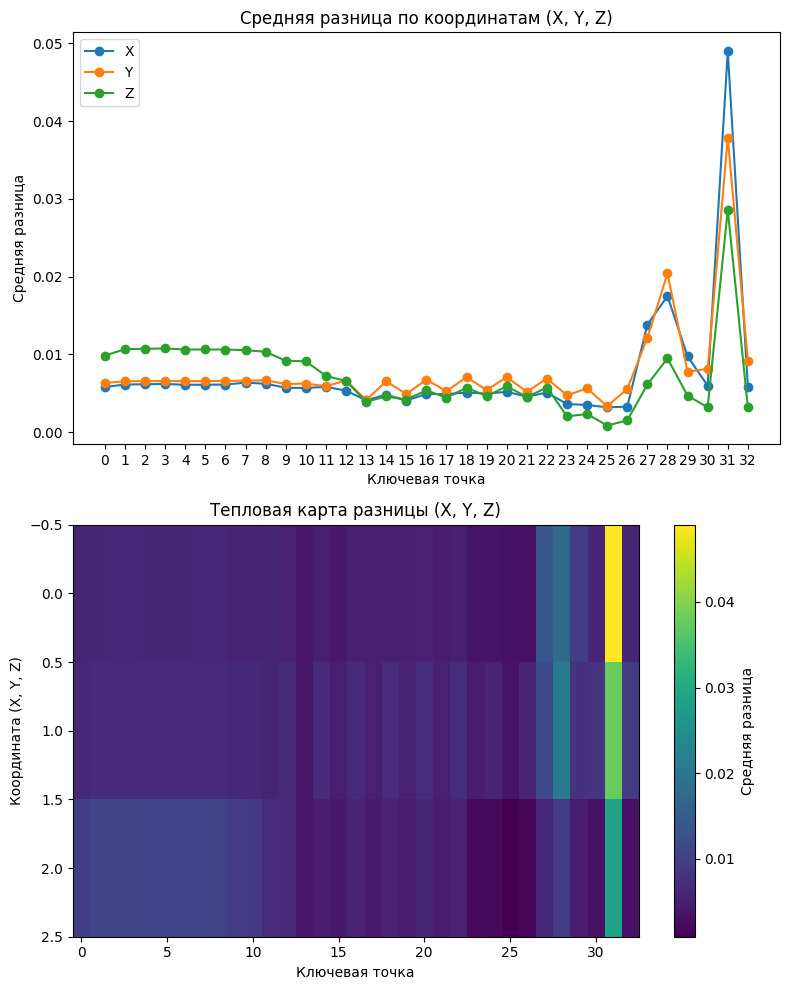

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = np.abs(frames_3d_1 - frames_3d_2)

# Средняя разница для каждой ключевой точки по всем кадрам
mean_difference_per_keypoint = np.nanmean(difference, axis=0)  # Усреднение по кадрам (остаются ключевые точки и координаты)

# Вывод результатов
print("Средняя разница для каждой ключевой точки (X, Y, Z):")
for i, mean_diff in enumerate(mean_difference_per_keypoint):
    print(f"Точка {i}: {mean_diff}")

# Визуализация разницы
plt.figure(figsize=(8, 10))  # Изменяем размер фигуры для вертикального расположения

# График средней разницы по всем точкам
plt.subplot(2, 1, 1)  # Две строки, один столбец, первый график
x = np.arange(len(mean_difference_per_keypoint))  # Индексы ключевых точек
plt.plot(x, mean_difference_per_keypoint[:, 0], label="X", marker='o')
plt.plot(x, mean_difference_per_keypoint[:, 1], label="Y", marker='o')
plt.plot(x, mean_difference_per_keypoint[:, 2], label="Z", marker='o')

# Добавление промежуточных осей
plt.xticks(ticks=x, labels=[str(i) for i in x])  # Явное указание меток для ключевых точек
plt.title("Средняя разница по координатам (X, Y, Z)")
plt.xlabel("Ключевая точка")
plt.ylabel("Средняя разница")
plt.legend()

# Тепловая карта разницы
plt.subplot(2, 1, 2)  # Две строки, один столбец, второй график
heatmap = mean_difference_per_keypoint  # Уже содержит среднюю разницу для каждой точки (num_keypoints x 3)
plt.imshow(heatmap.T, cmap='viridis', aspect='auto')
plt.colorbar(label="Средняя разница")
plt.title("Тепловая карта разницы (X, Y, Z)")
plt.xlabel("Ключевая точка")
plt.ylabel("Координата (X, Y, Z)")

plt.tight_layout()
plt.show()

Приведенное изменение в пространстве для каждой ключевой точки:
Точка 0: 0.013535292163460012
Точка 1: 0.01443269760253427
Точка 2: 0.014490947277785365
Точка 3: 0.014545231675534162
Точка 4: 0.014390816260162208
Точка 5: 0.014411398551291981
Точка 6: 0.014433975292379381
Точка 7: 0.014472396874826137
Точка 8: 0.014310128395703949
Точка 9: 0.012918557114762412
Точка 10: 0.012878569202218136
Точка 11: 0.011405006707244493
Точка 12: 0.011284904290191489
Точка 13: 0.007535440841079713
Точка 14: 0.009696387341888485
Точка 15: 0.00835644016841909
Точка 16: 0.010405354398477814
Точка 17: 0.009318751996695655
Точка 18: 0.010986053060360804
Точка 19: 0.009561458788799965
Точка 20: 0.011163187591392015
Точка 21: 0.00905674750737844
Точка 22: 0.010878832413168742
Точка 23: 0.006703684068337593
Точка 24: 0.0074087985073722174
Точка 25: 0.005050470006569398
Точка 26: 0.006972574525242117
Точка 27: 0.020416439611546
Точка 28: 0.029233597689537365
Точка 29: 0.014343399138517914
Точка 30: 0.011137532

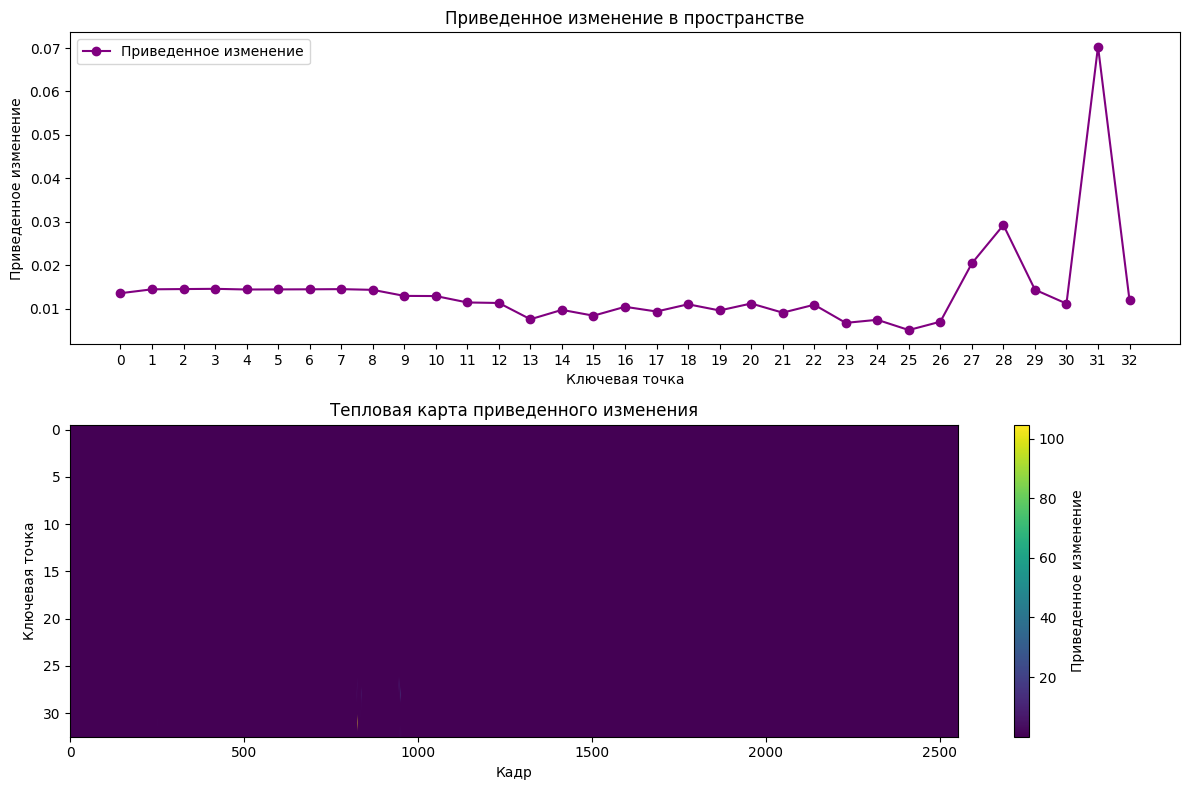

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = np.abs(frames_3d_1 - frames_3d_2)

# Приведенное изменение в пространстве (евклидова норма)
euclidean_change_per_keypoint = np.sqrt(np.nansum(difference**2, axis=2))  # (num_frames, num_keypoints)

# Усреднение по кадрам
mean_euclidean_change_per_keypoint = np.nanmean(euclidean_change_per_keypoint, axis=0)  # (num_keypoints,)

# Вывод результатов
print("Приведенное изменение в пространстве для каждой ключевой точки:")
for i, mean_change in enumerate(mean_euclidean_change_per_keypoint):
    print(f"Точка {i}: {mean_change}")

# Визуализация
plt.figure(figsize=(12, 8))

# График приведенного изменения в пространстве
plt.subplot(2, 1, 1)  # Две строки, один столбец, первый график
x = np.arange(len(mean_euclidean_change_per_keypoint))  # Индексы ключевых точек
plt.plot(x, mean_euclidean_change_per_keypoint, label="Приведенное изменение", marker='o', color='purple')

# Добавление промежуточных осей
plt.xticks(ticks=x, labels=[str(i) for i in x])  # Явное указание меток для ключевых точек
plt.title("Приведенное изменение в пространстве")
plt.xlabel("Ключевая точка")
plt.ylabel("Приведенное изменение")
plt.legend()

# Тепловая карта приведенного изменения
plt.subplot(2, 1, 2)  # Две строки, один столбец, второй график
heatmap = euclidean_change_per_keypoint.T  # Транспонируем для тепловой карты
plt.imshow(heatmap, cmap='viridis', aspect='auto')
plt.colorbar(label="Приведенное изменение")
plt.title("Тепловая карта приведенного изменения")
plt.xlabel("Кадр")
plt.ylabel("Ключевая точка")

plt.tight_layout()
plt.show()

Самые сильные изменения происходят в кадре 826 с общим изменением 109.501104


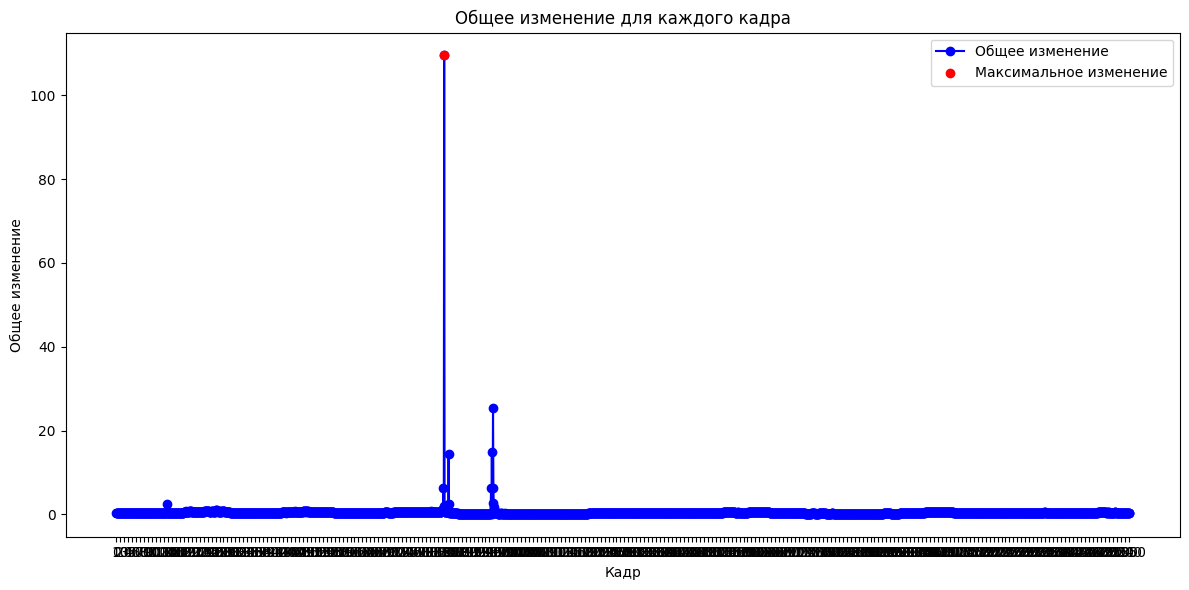

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = np.abs(frames_3d_1 - frames_3d_2)

# Приведенное изменение в пространстве (евклидова норма)
euclidean_change_per_keypoint = np.sqrt(np.nansum(difference**2, axis=2))  # (num_frames, num_keypoints)

# Общее изменение для каждого кадра
total_change_per_frame = np.nansum(euclidean_change_per_keypoint, axis=1)  # (num_frames,)

# Поиск кадра с максимальным изменением
max_change_frame_index = np.nanargmax(total_change_per_frame)
max_change_value = total_change_per_frame[max_change_frame_index]

print(f"Самые сильные изменения происходят в кадре {max_change_frame_index} с общим изменением {max_change_value:.6f}")

# Визуализация
plt.figure(figsize=(12, 6))

# График общего изменения для каждого кадра
plt.subplot(1, 1, 1)
x = np.arange(len(total_change_per_frame))  # Индексы кадров
plt.plot(x, total_change_per_frame, label="Общее изменение", marker='o', color='blue')
plt.scatter(max_change_frame_index, max_change_value, color='red', label="Максимальное изменение", zorder=5)

# Добавление меток осей
plt.xticks(ticks=x[::10], labels=[str(i) for i in x[::10]])  # Отображаем каждую 10-ю метку для читаемости
plt.title("Общее изменение для каждого кадра")
plt.xlabel("Кадр")
plt.ylabel("Общее изменение")
plt.legend()

plt.tight_layout()
plt.show()

Кадры с наибольшим изменением:
Кадр 127: Общее изменение 2.422338
Кадр 838: Общее изменение 2.556710
Кадр 948: Общее изменение 2.778705
Кадр 944: Общее изменение 6.253075
Кадр 950: Общее изменение 6.344441
Кадр 824: Общее изменение 6.351415
Кадр 837: Общее изменение 14.410837
Кадр 946: Общее изменение 14.795481
Кадр 949: Общее изменение 25.421740
Кадр 826: Общее изменение 109.501104

Анализ кадра 127:
Среднее изменение по координатам (X, Y, Z): [0.04143318 0.06012512 0.00171476]
Наибольшее изменение происходит по координате Y.

Анализ кадра 838:
Среднее изменение по координатам (X, Y, Z): [0.0559305  0.04296348 0.02989823]
Наибольшее изменение происходит по координате X.

Анализ кадра 948:
Среднее изменение по координатам (X, Y, Z): [0.0463416  0.0620955  0.02992047]
Наибольшее изменение происходит по координате Y.

Анализ кадра 944:
Среднее изменение по координатам (X, Y, Z): [0.13043295 0.12078805 0.06303176]
Наибольшее изменение происходит по координате X.

Анализ кадра 950:
Среднее

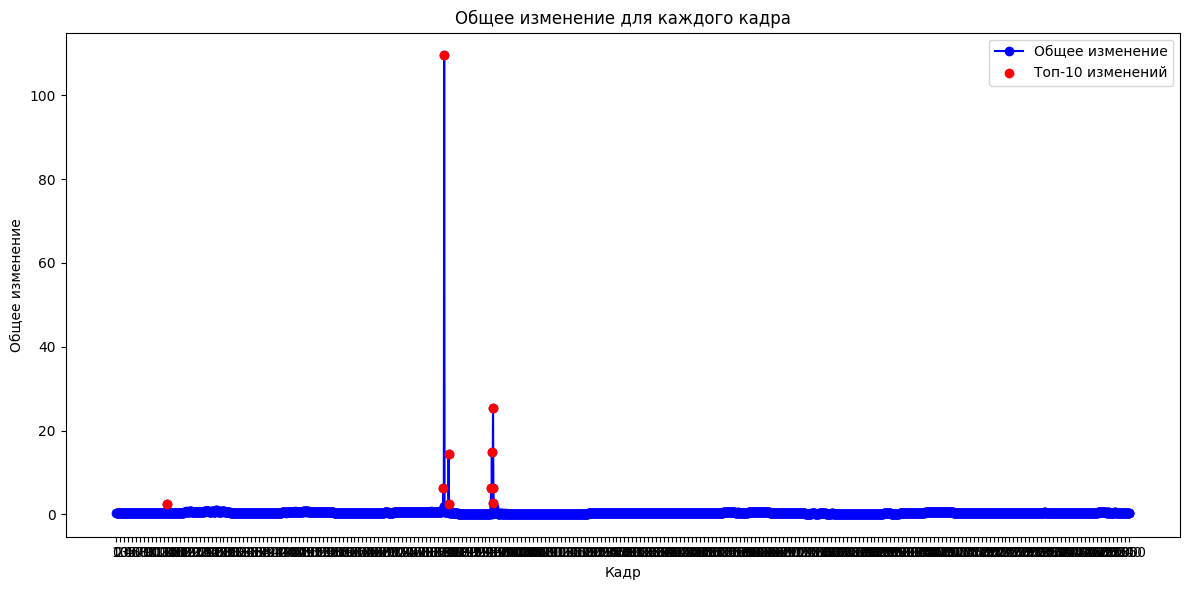

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = np.abs(frames_3d_1 - frames_3d_2)

# Приведенное изменение в пространстве (евклидова норма)
euclidean_change_per_keypoint = np.sqrt(np.nansum(difference**2, axis=2))  # (num_frames, num_keypoints)

# Общее изменение для каждого кадра
total_change_per_frame = np.nansum(euclidean_change_per_keypoint, axis=1)  # (num_frames,)

# Выбор 10 кадров с наибольшим изменением
top_n = 10
top_indices = np.argsort(total_change_per_frame)[-top_n:]  # Индексы кадров с наибольшим изменением
top_changes = total_change_per_frame[top_indices]  # Значения изменений для этих кадров

print(f"Кадры с наибольшим изменением:")
for i, idx in enumerate(top_indices):
    print(f"Кадр {idx}: Общее изменение {top_changes[i]:.6f}")

# Анализ изменений по координатам для выбранных кадров
for idx in top_indices:
    print(f"\nАнализ кадра {idx}:")
    frame_difference = difference[idx]  # Разница для данного кадра
    mean_change_per_coordinate = np.nanmean(frame_difference, axis=0)  # Среднее изменение по координатам (X, Y, Z)

    print(f"Среднее изменение по координатам (X, Y, Z): {mean_change_per_coordinate}")
    if mean_change_per_coordinate[0] > mean_change_per_coordinate[1] and mean_change_per_coordinate[0] > mean_change_per_coordinate[2]:
        print("Наибольшее изменение происходит по координате X.")
    elif mean_change_per_coordinate[1] > mean_change_per_coordinate[0] and mean_change_per_coordinate[1] > mean_change_per_coordinate[2]:
        print("Наибольшее изменение происходит по координате Y.")
    else:
        print("Наибольшее изменение происходит по координате Z.")

# Визуализация
plt.figure(figsize=(12, 6))

# График общего изменения для каждого кадра
plt.subplot(1, 1, 1)
x = np.arange(len(total_change_per_frame))  # Индексы кадров
plt.plot(x, total_change_per_frame, label="Общее изменение", marker='o', color='blue')
plt.scatter(top_indices, total_change_per_frame[top_indices], color='red', label=f"Топ-{top_n} изменений", zorder=5)

# Добавление меток осей
plt.xticks(ticks=x[::10], labels=[str(i) for i in x[::10]])  # Отображаем каждую 10-ю метку для читаемости
plt.title("Общее изменение для каждого кадра")
plt.xlabel("Кадр")
plt.ylabel("Общее изменение")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = frames_3d_1 - frames_3d_2  # Разница (до - после)

# Кадры с наибольшим изменением
top_frames = [127, 838, 948, 944, 950, 824, 837, 946, 949, 826]

# Анализ изменений для каждого кадра
for frame_idx in top_frames:
    print(f"\nАнализ кадра {frame_idx}:")
    frame_diff = difference[frame_idx]  # Разница для данного кадра

    # Анализ для каждой ключевой точки
    for keypoint_idx, keypoint_diff in enumerate(frame_diff):
        x_diff, y_diff, z_diff = keypoint_diff

        # Вывод изменений для каждой координаты
        print(f"Точка {keypoint_idx}:")
        if x_diff > 0:
            print(f"  X: Увеличение на {x_diff:.6f}")
        elif x_diff < 0:
            print(f"  X: Уменьшение на {-x_diff:.6f}")
        else:
            print("  X: Нет изменений")

        if y_diff > 0:
            print(f"  Y: Увеличение на {y_diff:.6f}")
        elif y_diff < 0:
            print(f"  Y: Уменьшение на {-y_diff:.6f}")
        else:
            print("  Y: Нет изменений")

        if z_diff > 0:
            print(f"  Z: Увеличение на {z_diff:.6f}")
        elif z_diff < 0:
            print(f"  Z: Уменьшение на {-z_diff:.6f}")
        else:
            print("  Z: Нет изменений")


Анализ кадра 127:
Точка 0:
  X: Увеличение на 0.099271
  Y: Увеличение на 0.146334
  Z: Увеличение на 0.001267
Точка 1:
  X: Увеличение на 0.131095
  Y: Увеличение на 0.193726
  Z: Уменьшение на 0.000751
Точка 2:
  X: Увеличение на 0.133947
  Y: Увеличение на 0.199119
  Z: Уменьшение на 0.001255
Точка 3:
  X: Увеличение на 0.131286
  Y: Увеличение на 0.196324
  Z: Уменьшение на 0.001159
Точка 4:
  X: Увеличение на 0.130518
  Y: Увеличение на 0.189841
  Z: Уменьшение на 0.000165
Точка 5:
  X: Увеличение на 0.129455
  Y: Увеличение на 0.187391
  Z: Увеличение на 0.000092
Точка 6:
  X: Увеличение на 0.128493
  Y: Увеличение на 0.185072
  Z: Увеличение на 0.000235
Точка 7:
  X: Увеличение на 0.089636
  Y: Увеличение на 0.136488
  Z: Увеличение на 0.003027
Точка 8:
  X: Увеличение на 0.114913
  Y: Увеличение на 0.164877
  Z: Уменьшение на 0.000228
Точка 9:
  X: Увеличение на 0.076695
  Y: Увеличение на 0.114786
  Z: Увеличение на 0.002428
Точка 10:
  X: Увеличение на 0.078690
  Y: Увеличен

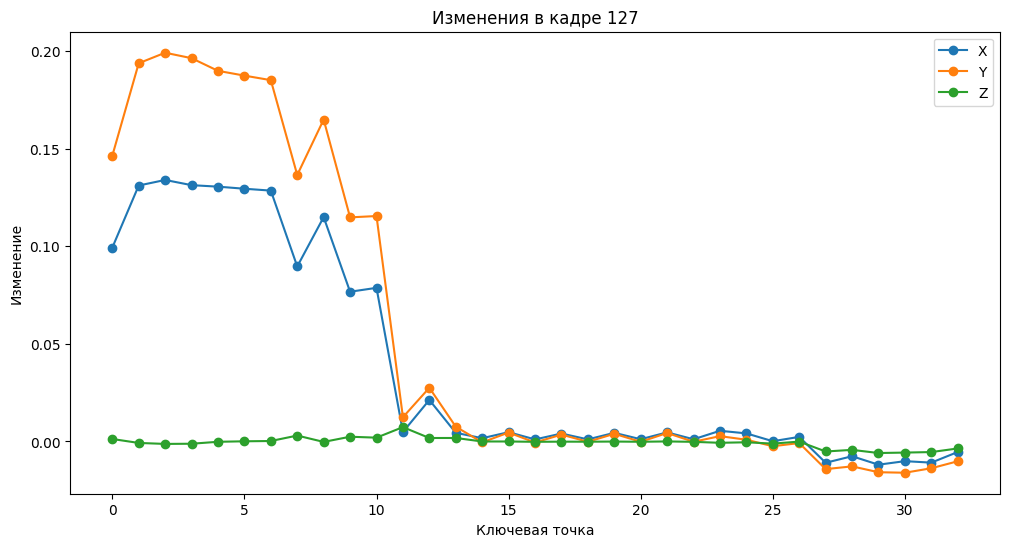

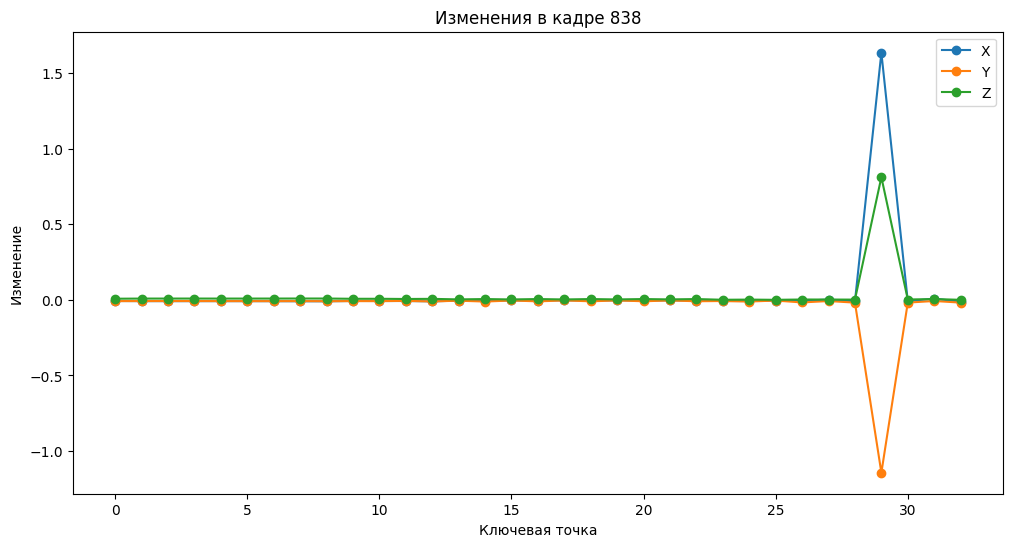

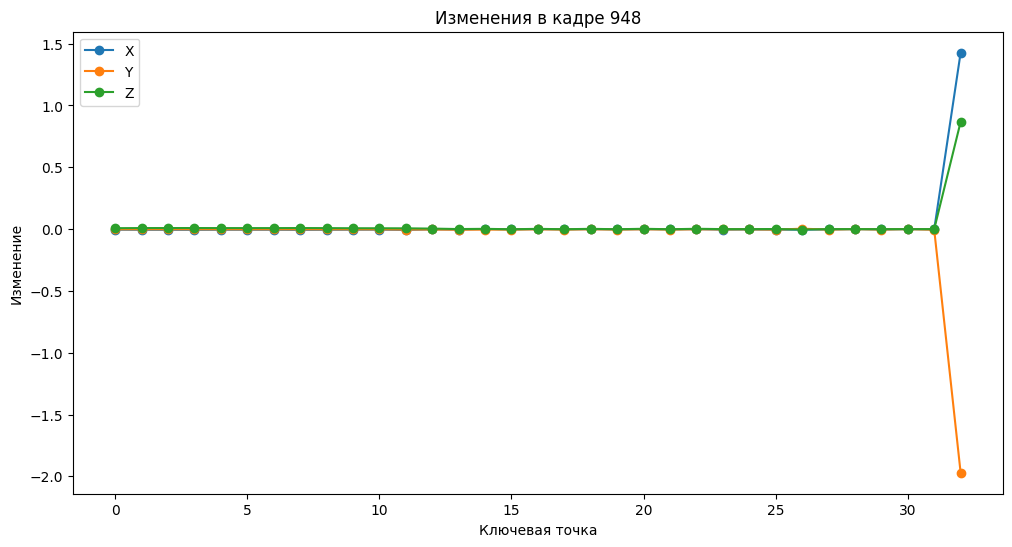

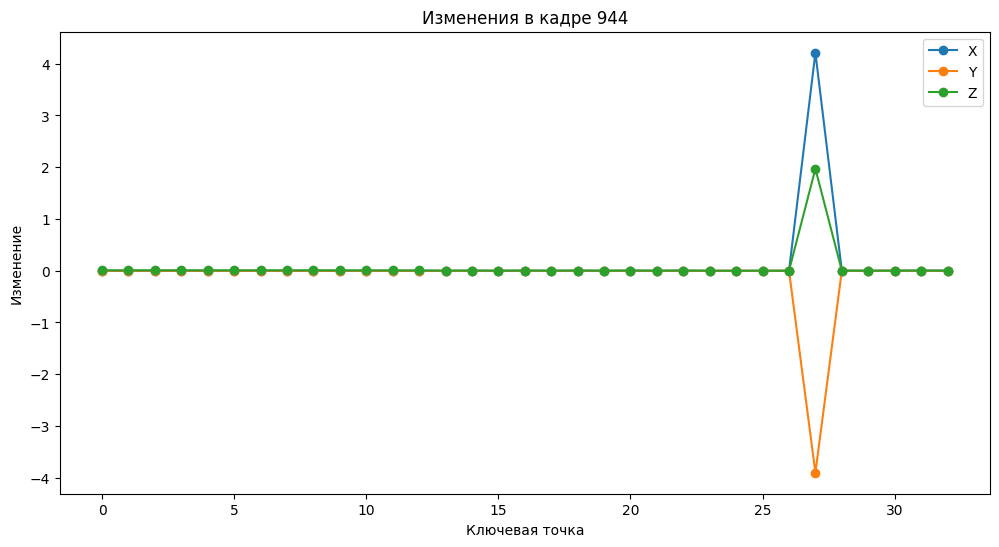

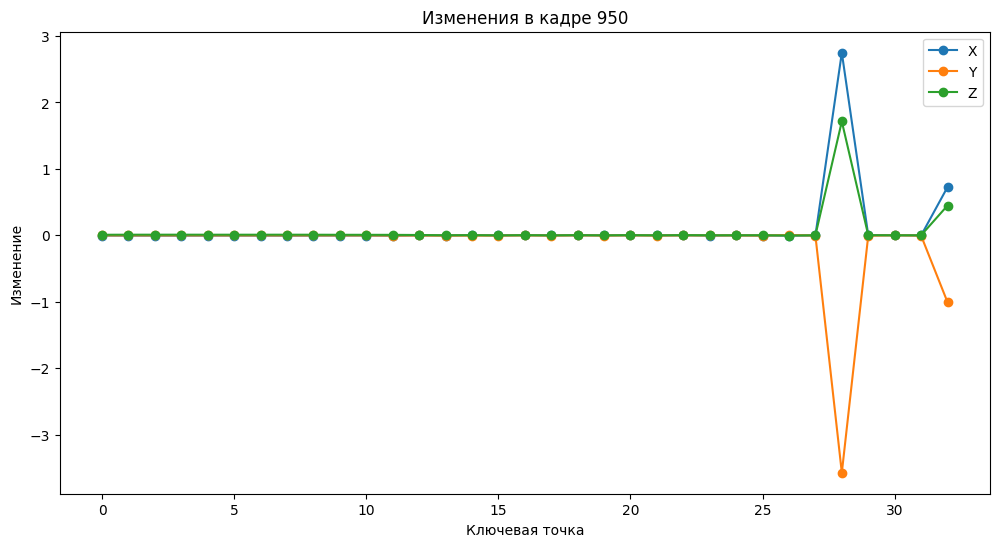

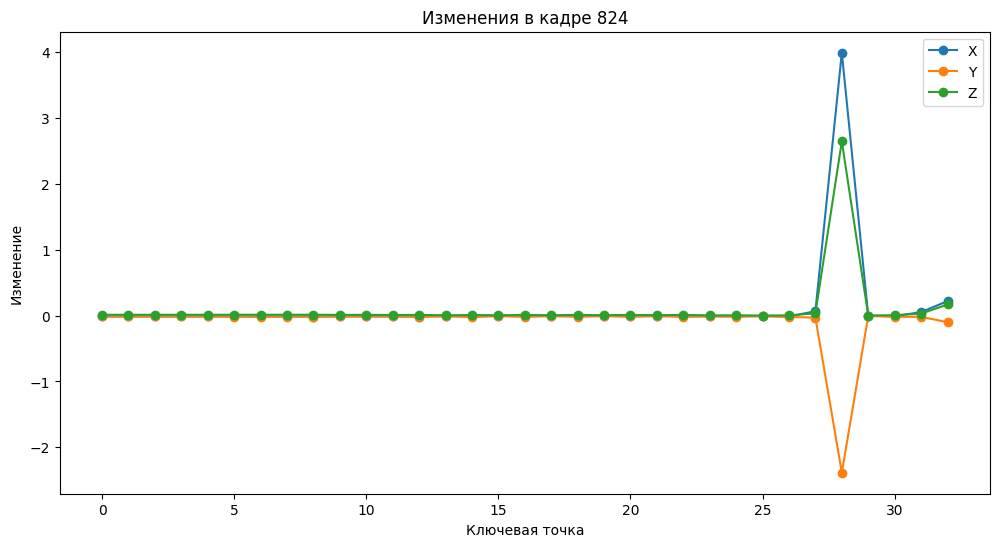

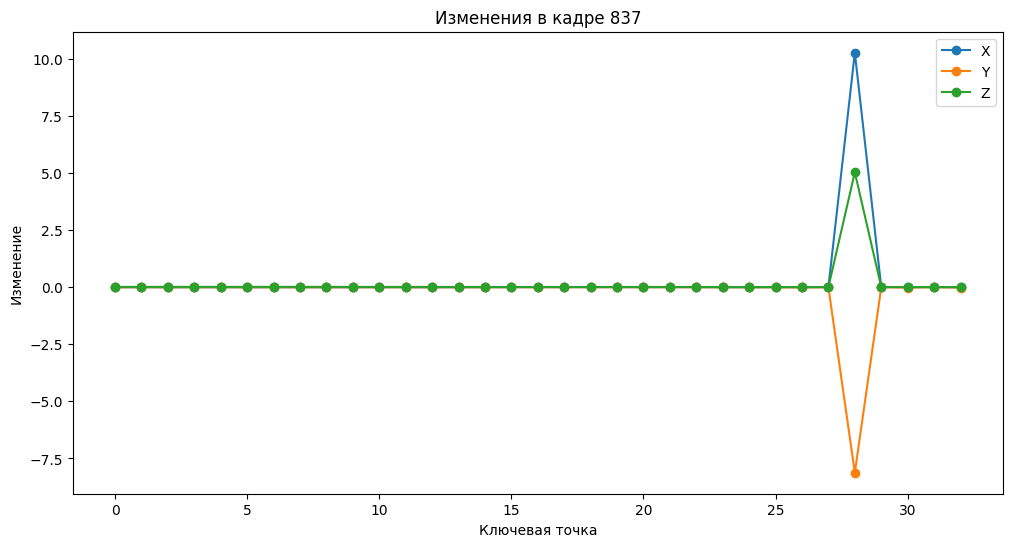

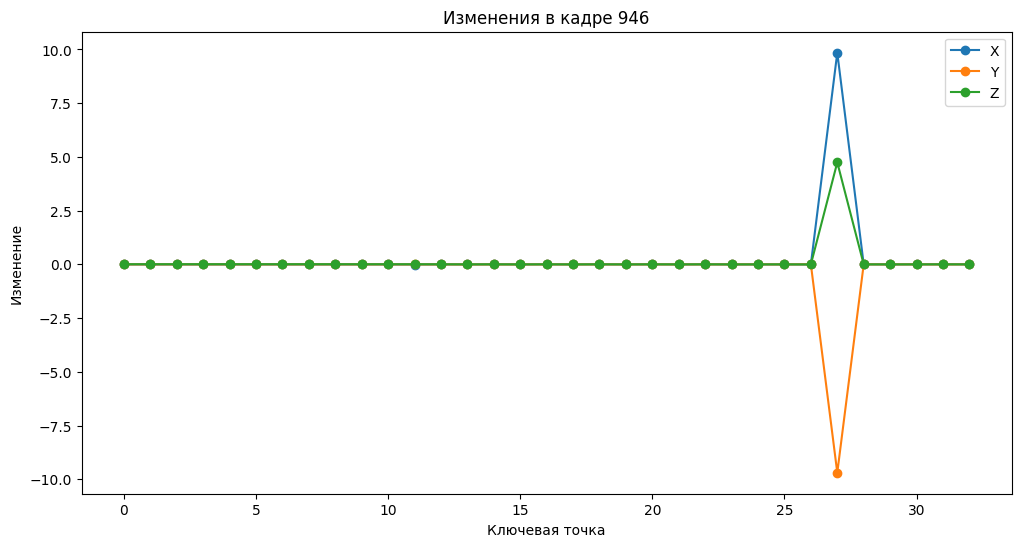

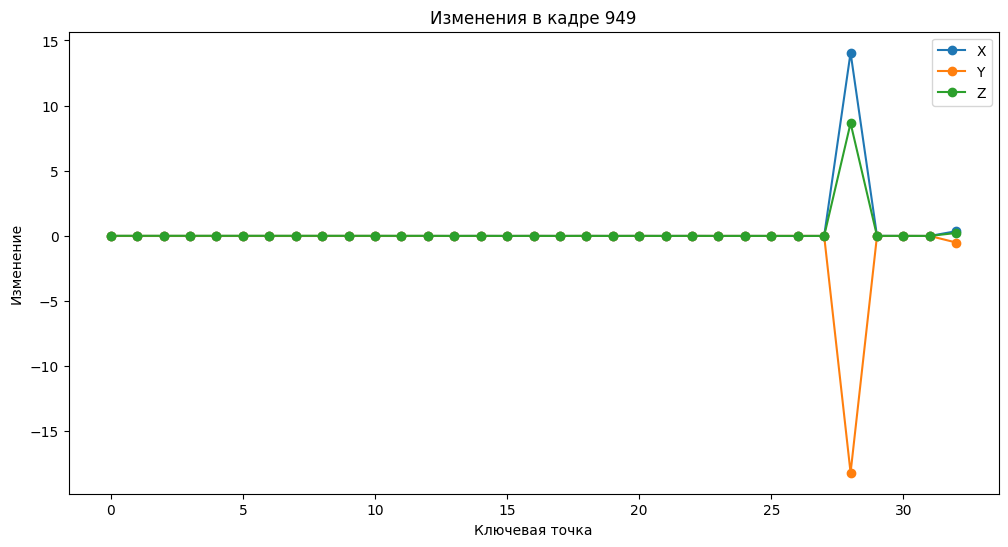

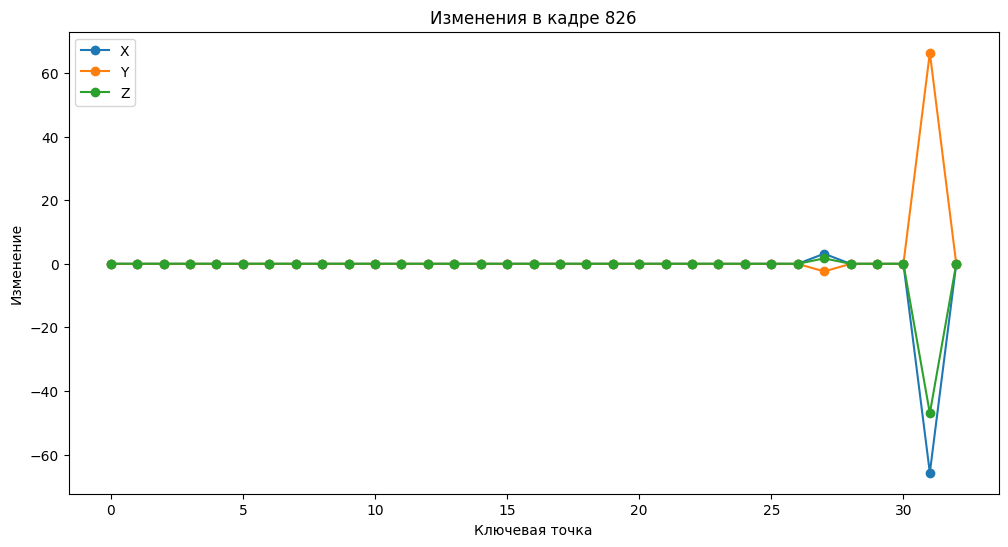

In [ ]:
import matplotlib.pyplot as plt

for frame_idx in top_frames:
    frame_diff = difference[frame_idx]
    plt.figure(figsize=(12, 6))
    plt.plot(frame_diff[:, 0], label="X", marker='o')
    plt.plot(frame_diff[:, 1], label="Y", marker='o')
    plt.plot(frame_diff[:, 2], label="Z", marker='o')
    plt.title(f"Изменения в кадре {frame_idx}")
    plt.xlabel("Ключевая точка")
    plt.ylabel("Изменение")
    plt.legend()
    plt.show()

In [ ]:
mean_x_diff = np.mean(frame_diff[:, 0])
mean_y_diff = np.mean(frame_diff[:, 1])
mean_z_diff = np.mean(frame_diff[:, 2])
print(f"Среднее изменение: X={mean_x_diff:.6f}, Y={mean_y_diff:.6f}, Z={mean_z_diff:.6f}")

Среднее изменение: X=-1.905222, Y=1.927317, Z=-1.366267


In [ ]:
'''
Ключевые точки MediaPipe Pose
Точка 0 : Нос (Nose)
Точка 1 : Левый глаз (внутренний угол) (Left Eye Inner)
Точка 2 : Левый глаз (центр) (Left Eye)
Точка 3 : Левый глаз (внешний угол) (Left Eye Outer)
Точка 4 : Правый глаз (внутренний угол) (Right Eye Inner)
Точка 5 : Правый глаз (центр) (Right Eye)
Точка 6 : Правый глаз (внешний угол) (Right Eye Outer)
Точка 7 : Левое ухо (Left Ear)
Точка 8 : Правое ухо (Right Ear)
Точка 9 : Рот (левый угол) (Mouth Left)
Точка 10 : Рот (правый угол) (Mouth Right)
Точка 11 : Левое плечо (Left Shoulder)
Точка 12 : Правое плечо (Right Shoulder)
Точка 13 : Левый локоть (Left Elbow)
Точка 14 : Правый локоть (Right Elbow)
Точка 15 : Левое запястье (Left Wrist)
Точка 16 : Правое запястье (Right Wrist)
Точка 17 : Левая рука (кончик большого пальца) (Left Pinky)
Точка 18 : Правая рука (кончик большого пальца) (Right Pinky)
Точка 19 : Левая рука (кончик указательного пальца) (Left Index)
Точка 20 : Правая рука (кончик указательного пальца) (Right Index)
Точка 21 : Левая рука (кончик среднего пальца) (Left Thumb)
Точка 22 : Правая рука (кончик среднего пальца) (Right Thumb)
Точка 23 : Левое бедро (Left Hip)
Точка 24 : Правое бедро (Right Hip)
Точка 25 : Левое колено (Left Knee)
Точка 26 : Правое колено (Right Knee)
Точка 27 : Левая лодыжка (Left Ankle)
Точка 28 : Правая лодыжка (Right Ankle)
Точка 29 : Левая стопа (пятка) (Left Heel)
Точка 30 : Правая стопа (пятка) (Right Heel)
Точка 31 : Левая стопа (кончик пальцев) (Left Foot Index)
Точка 32 : Правая стопа (кончик пальцев) (Right Foot Index)
'''

In [ ]:
# Вычисление межквартильного размаха (IQR)
def compute_iqr(data):
    q1 = np.nanpercentile(data, 25, axis=0)  # 25-й процентиль
    q3 = np.nanpercentile(data, 75, axis=0)  # 75-й процентиль
    iqr = q3 - q1
    return iqr

# IQR до и после коррекции
iqr_before = compute_iqr(frames_3d_1)
iqr_after = compute_iqr(frames_3d_2)

# Разница в IQR
iqr_difference = iqr_after - iqr_before

print("Разница в межквартильном размахе (IQR):")
for i, diff in enumerate(iqr_difference):
    print(f"Точка {i}: {diff}")

Разница в межквартильном размахе (IQR):
Точка 0: [-0.00827691 -0.00562798 -0.00101293]
Точка 1: [-0.00909314 -0.00357551 -0.00122856]
Точка 2: [-0.00792661 -0.00726022 -0.00072677]
Точка 3: [-0.01003897 -0.00563094 -0.00130241]
Точка 4: [-0.0086286  -0.00698093 -0.00135635]
Точка 5: [-0.00757556 -0.00684845 -0.00089895]
Точка 6: [-0.00852638 -0.00356937 -0.00141624]
Точка 7: [-0.00786562 -0.00219027 -0.00297134]
Точка 8: [-0.00608951 -0.00540411 -0.00329157]
Точка 9: [-0.0081659  -0.00495824 -0.0010196 ]
Точка 10: [-0.00748693 -0.00584688 -0.00169453]
Точка 11: [-0.00955281 -0.00170843 -0.00154157]
Точка 12: [-0.00787317 -0.00752369 -0.00251725]
Точка 13: [-6.33273428e-03  4.99113383e-03 -5.45415933e-06]
Точка 14: [-0.008701   -0.00548769 -0.00111134]
Точка 15: [-0.00378794 -0.00201076 -0.00317823]
Точка 16: [-0.00701835 -0.00213548 -0.00440735]
Точка 17: [-0.00588694 -0.00096344 -0.00255617]
Точка 18: [-0.00609266 -0.00729704 -0.00453063]
Точка 19: [-0.00571461 -0.0042646  -0.00036096

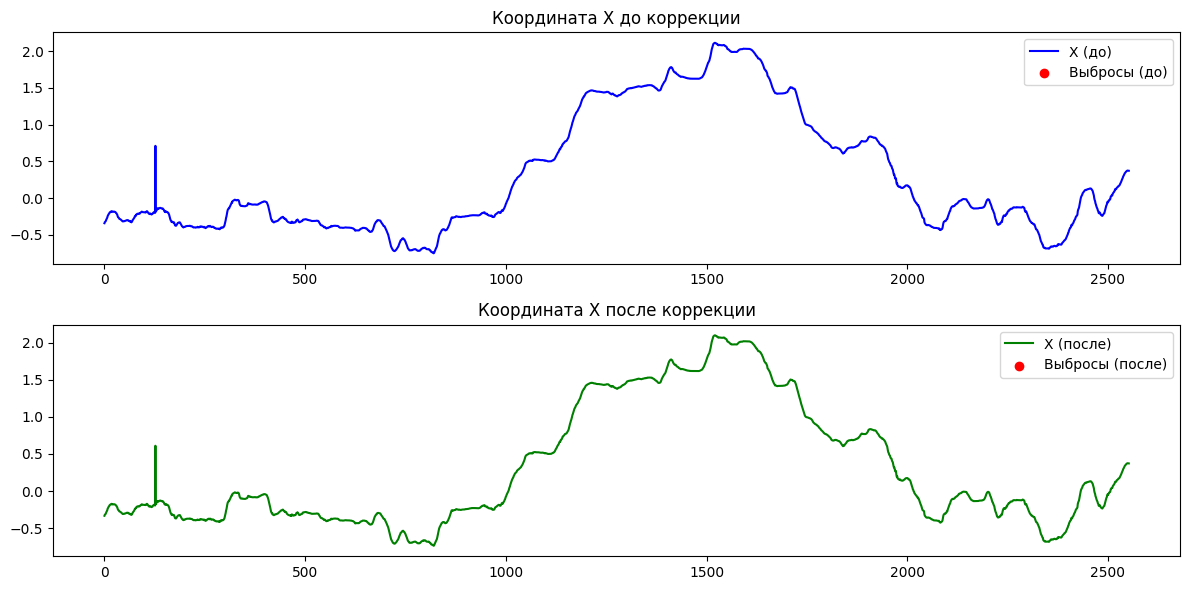

In [ ]:
import matplotlib.pyplot as plt

# Функция для выявления выбросов с помощью IQR
def detect_outliers(data):
    q1 = np.nanpercentile(data, 25, axis=0)
    q3 = np.nanpercentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data < lower_bound) | (data > upper_bound)

# Выявление выбросов до и после коррекции
outliers_before = detect_outliers(frames_3d_1)
outliers_after = detect_outliers(frames_3d_2)

# Визуализация
plt.figure(figsize=(12, 6))

# График для одной ключевой точки (например, Точка 0)
keypoint_index = 0
plt.subplot(2, 1, 1)
plt.plot(frames_3d_1[:, keypoint_index, 0], label="X (до)", color='blue')
plt.scatter(np.where(outliers_before[:, keypoint_index, 0])[0],
            frames_3d_1[outliers_before[:, keypoint_index, 0], keypoint_index, 0],
            color='red', label="Выбросы (до)", zorder=5)
plt.title("Координата X до коррекции")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(frames_3d_2[:, keypoint_index, 0], label="X (после)", color='green')
plt.scatter(np.where(outliers_after[:, keypoint_index, 0])[0],
            frames_3d_2[outliers_after[:, keypoint_index, 0], keypoint_index, 0],
            color='red', label="Выбросы (после)", zorder=5)
plt.title("Координата X после коррекции")
plt.legend()

plt.tight_layout()
plt.show()

  plt.boxplot(data_to_plot, labels=["До", "После"])



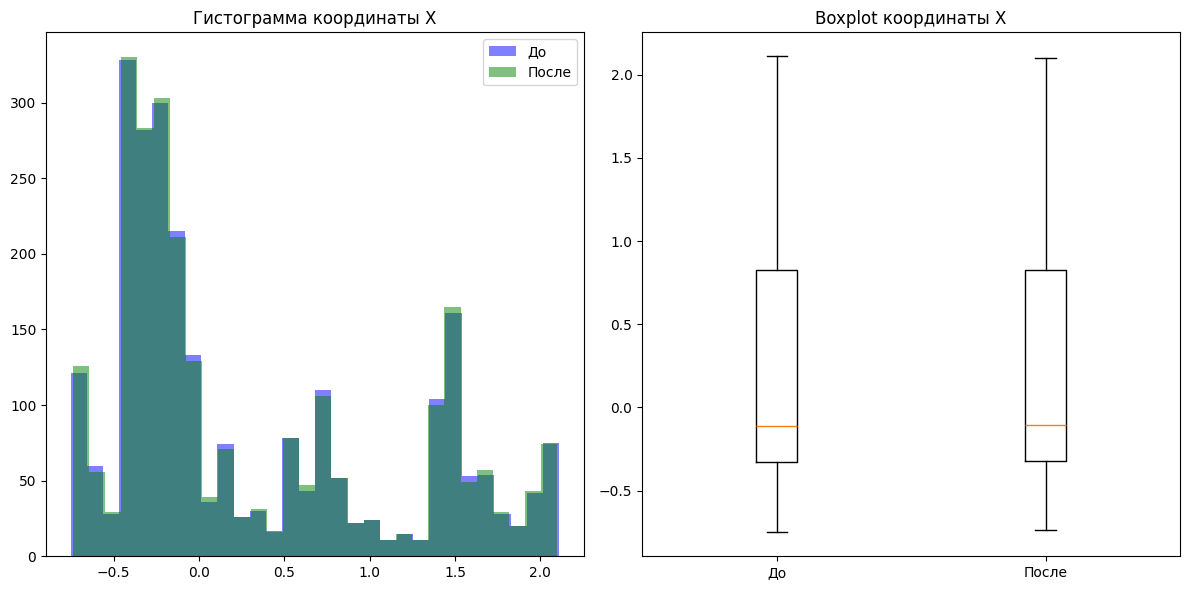

In [ ]:
plt.figure(figsize=(12, 6))

# Гистограммы для одной ключевой точки (например, Точка 0)
keypoint_index = 0
plt.subplot(1, 2, 1)
plt.hist(frames_3d_1[:, keypoint_index, 0].flatten(), bins=30, alpha=0.5, label="До", color='blue')
plt.hist(frames_3d_2[:, keypoint_index, 0].flatten(), bins=30, alpha=0.5, label="После", color='green')
plt.title("Гистограмма координаты X")
plt.legend()

# Boxplot для сравнения
plt.subplot(1, 2, 2)
data_to_plot = [frames_3d_1[:, keypoint_index, 0].flatten(), frames_3d_2[:, keypoint_index, 0].flatten()]
plt.boxplot(data_to_plot, labels=["До", "После"])
plt.title("Boxplot координаты X")

plt.tight_layout()
plt.show()

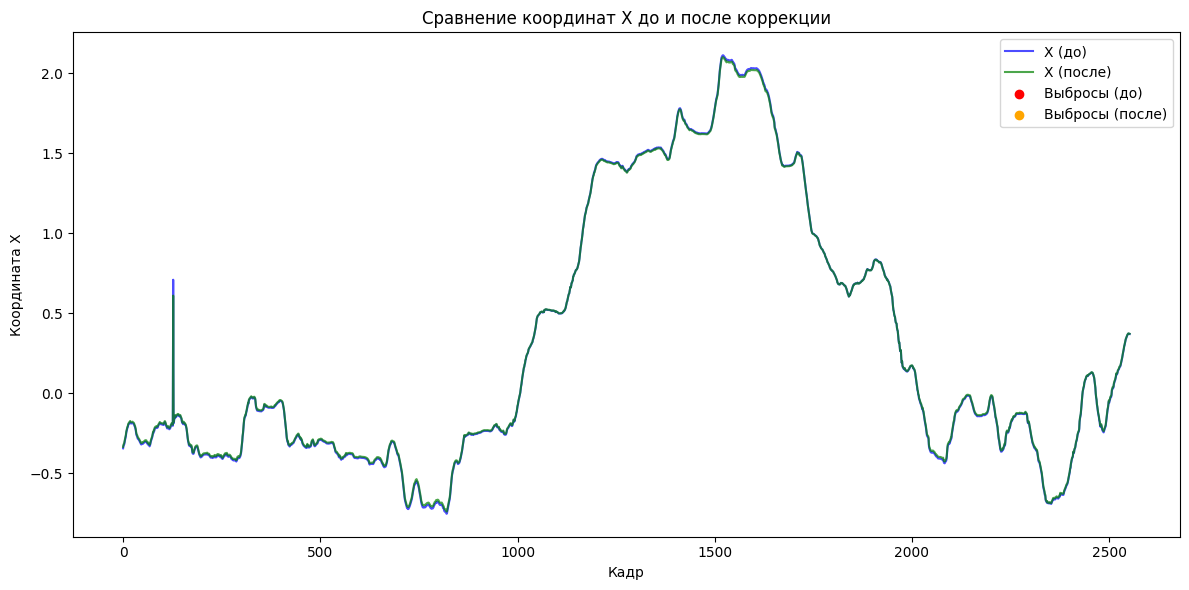

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для выявления выбросов с помощью IQR
def detect_outliers(data):
    q1 = np.nanpercentile(data, 25, axis=0)
    q3 = np.nanpercentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data < lower_bound) | (data > upper_bound)

# Выявление выбросов до и после коррекции
outliers_before = detect_outliers(frames_3d_1)
outliers_after = detect_outliers(frames_3d_2)

# Визуализация
plt.figure(figsize=(12, 6))

# График для одной ключевой точки (например, Точка 0)
keypoint_index = 0

# Наложение графиков
plt.plot(frames_3d_1[:, keypoint_index, 0], label="X (до)", color='blue', alpha=0.7)
plt.plot(frames_3d_2[:, keypoint_index, 0], label="X (после)", color='green', alpha=0.7)

# Выделение выбросов
plt.scatter(
    np.where(outliers_before[:, keypoint_index, 0])[0],
    frames_3d_1[outliers_before[:, keypoint_index, 0], keypoint_index, 0],
    color='red', label="Выбросы (до)", zorder=5
)
plt.scatter(
    np.where(outliers_after[:, keypoint_index, 0])[0],
    frames_3d_2[outliers_after[:, keypoint_index, 0], keypoint_index, 0],
    color='orange', label="Выбросы (после)", zorder=5
)

# Настройка графика
plt.title("Сравнение координат X до и после коррекции")
plt.xlabel("Кадр")
plt.ylabel("Координата X")
plt.legend()

plt.tight_layout()
plt.show()

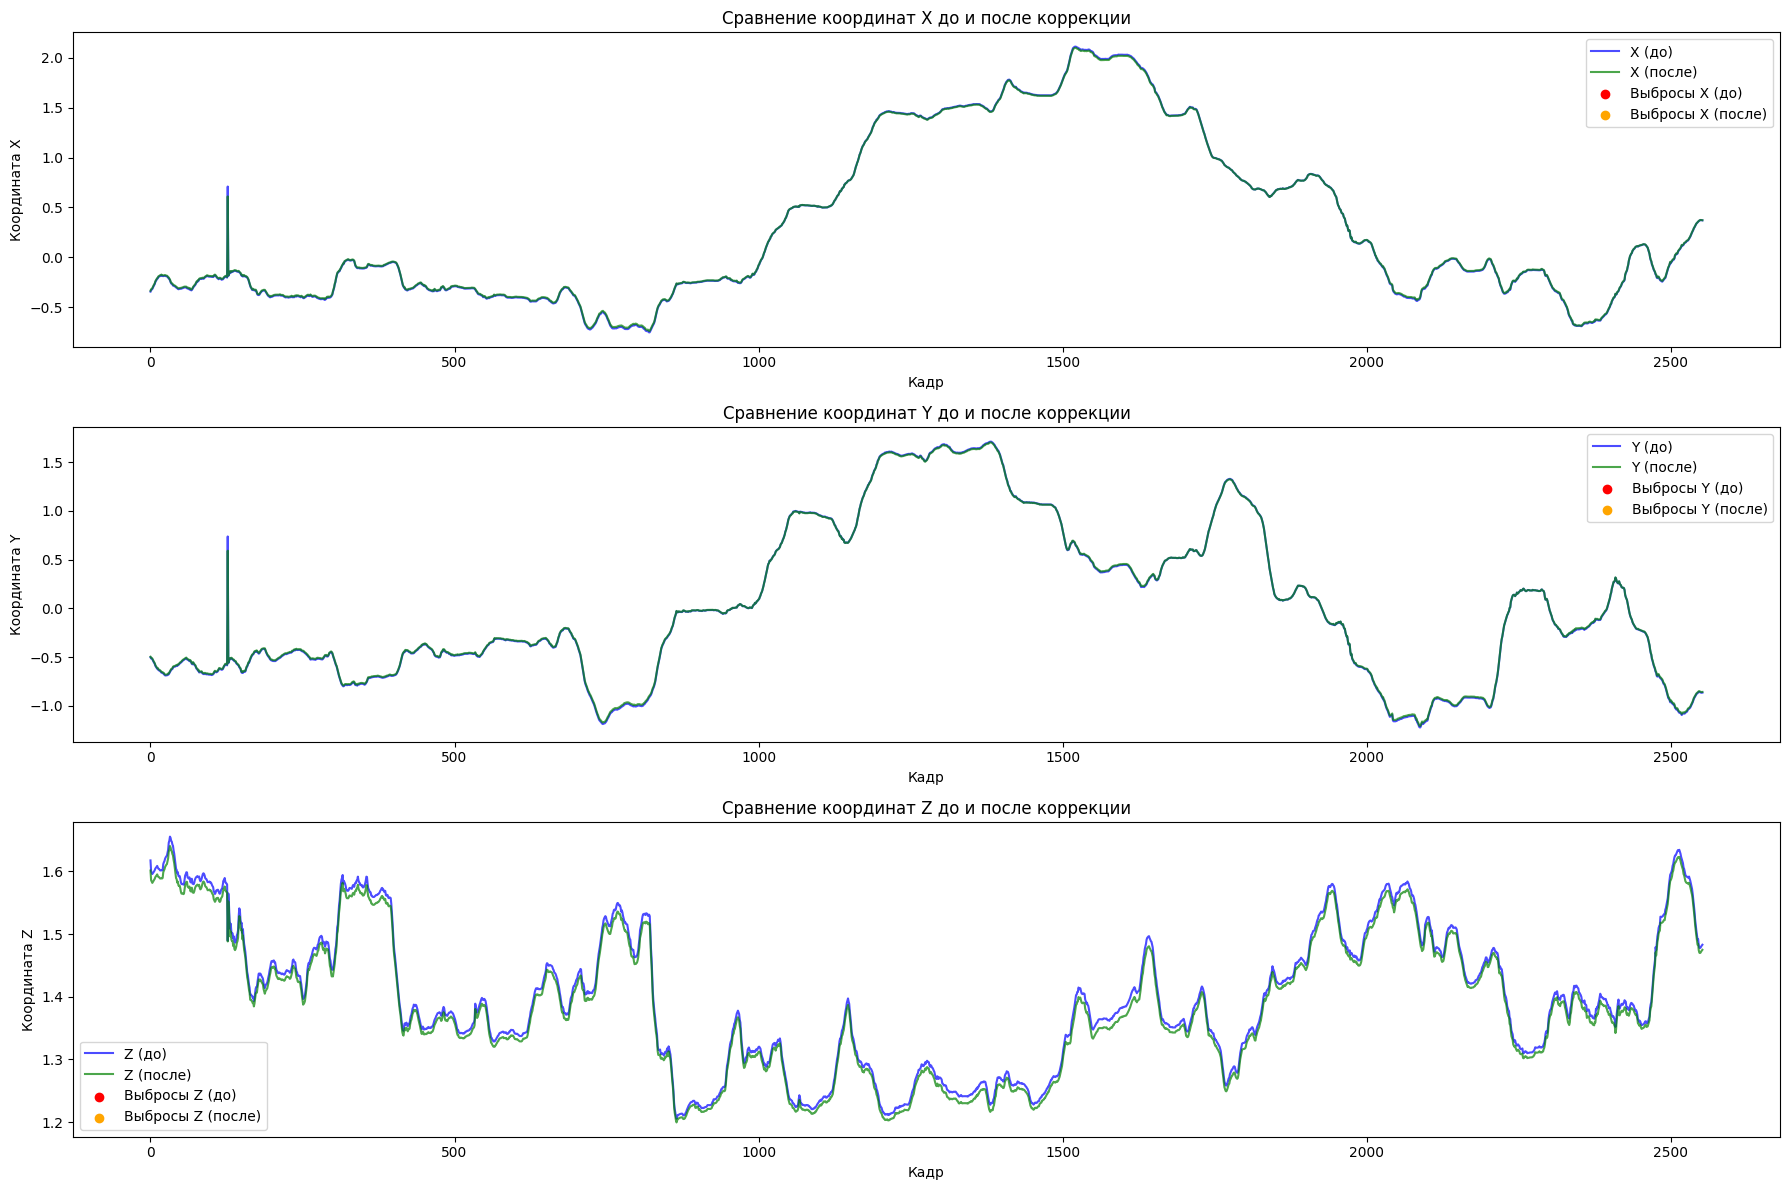

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для выявления выбросов с помощью IQR
def detect_outliers(data):
    q1 = np.nanpercentile(data, 25, axis=0)
    q3 = np.nanpercentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data < lower_bound) | (data > upper_bound)

# Выявление выбросов до и после коррекции
outliers_before = detect_outliers(frames_3d_1)
outliers_after = detect_outliers(frames_3d_2)

# Визуализация
plt.figure(figsize=(18, 12))  # Увеличиваем размер фигуры под три графика

# Для каждой координаты (X, Y, Z)
for coord_index, coord_name in enumerate(["X", "Y", "Z"]):
    plt.subplot(3, 1, coord_index + 1)  # Три строки, один столбец
    keypoint_index = 0  # Например, Точка 0

    # Наложение графиков
    plt.plot(frames_3d_1[:, keypoint_index, coord_index], label=f"{coord_name} (до)", color='blue', alpha=0.7)
    plt.plot(frames_3d_2[:, keypoint_index, coord_index], label=f"{coord_name} (после)", color='green', alpha=0.7)

    # Выделение выбросов
    plt.scatter(
        np.where(outliers_before[:, keypoint_index, coord_index])[0],
        frames_3d_1[outliers_before[:, keypoint_index, coord_index], keypoint_index, coord_index],
        color='red', label=f"Выбросы {coord_name} (до)", zorder=5
    )
    plt.scatter(
        np.where(outliers_after[:, keypoint_index, coord_index])[0],
        frames_3d_2[outliers_after[:, keypoint_index, coord_index], keypoint_index, coord_index],
        color='orange', label=f"Выбросы {coord_name} (после)", zorder=5
    )

    # Настройка графика
    plt.title(f"Сравнение координат {coord_name} до и после коррекции")
    plt.xlabel("Кадр")
    plt.ylabel(f"Координата {coord_name}")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
np.save("/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy", frames_3d)

In [ ]:
!rm -f /content/frames/*

In [ ]:
import os
import subprocess
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import gc

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для генерации кадров
def generate_frames(frames_3d, output_dir, batch_size=100):
    os.makedirs(output_dir, exist_ok=True)

    num_frames = frames_3d.shape[0]  # Общее количество кадров
    print(f"Общее количество кадров: {num_frames}")

    for batch_start in range(0, num_frames, batch_size):
        batch_end = min(batch_start + batch_size, num_frames)
        print(f"Обработка пакета: {batch_start} - {batch_end}")

        # Создание нового графика для каждого пакета
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111, projection='3d')
        plt.ioff()  # Отключаем интерактивный режим

        for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
            # Очистка предыдущего кадра
            ax.clear()

            # Извлечение координат для выбранного кадра
            keypoints = frames_3d[frame_index]  # (33, 3)

            # Проверка данных
            if np.isnan(keypoints).any() or np.isinf(keypoints).any():
                print(f"Некорректные данные для кадра {frame_index}")
                continue

            # Отображение точек
            x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]
            ax.scatter(x, y, z, c='red', s=10)

            # Отображение связей между точками
            for start, end in connections:
                xs = [keypoints[start][0], keypoints[end][0]]
                ys = [keypoints[start][1], keypoints[end][1]]
                zs = [keypoints[start][2], keypoints[end][2]]
                ax.plot(xs, ys, zs, c='blue')

            # Настройка осей на основе данных
            all_x = frames_3d[:, :, 0].flatten()
            all_y = frames_3d[:, :, 1].flatten()
            all_z = frames_3d[:, :, 2].flatten()

            # Исключаем NaN и Inf при расчете пределов осей
            valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
            valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
            valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

            if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
                # Ограничение оси X: минимальное значение -10, максимальное — рассчитывается
                ax.set_xlim(-1, 3)
                ax.set_ylim(-1, 3)
                ax.set_zlim(0, 2)
            else:
                print("No valid data to set axis limits. Skipping...")
                return

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f"Frame {frame_index}")

            # Сохранение кадра
            frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
            plt.savefig(frame_path, format='jpg', dpi=75)  # Уменьшаем разрешение
            #print(f"Сохранение кадра: {frame_path}")

        # Очистка памяти после обработки пакета
        plt.close(fig)
        del keypoints, x, y, z
        gc.collect()

# Функция для изменения размеров изображений
def adjust_image_sizes(output_dir, target_size):
    """
    Изменяет размеры всех изображений в директории до целевого размера.
    :param output_dir: Директория с изображениями.
    :param target_size: Целевой размер (ширина, высота).
    """
    for filename in os.listdir(output_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(output_dir, filename)
            img = Image.open(img_path)
            img_resized = img.resize(target_size)
            img_resized.save(img_path)

# Генерация кадров
output_dir = "/content/frames"
generate_frames(frames_3d, output_dir)

# Корректировка размеров изображений
original_width, original_height = plt.gcf().get_size_inches() * plt.gcf().dpi
target_size = (int(original_width // 2 * 2), int(original_height // 2 * 2))  # Размеры, кратные 2
adjust_image_sizes(output_dir, target_size)

print(f"Размеры изображений изменены на {target_size}.")

Общее количество кадров: 2553
Обработка пакета: 0 - 100


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.10frame/s]


Обработка пакета: 100 - 200


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.39frame/s]


Обработка пакета: 200 - 300


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.14frame/s]


Обработка пакета: 300 - 400


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.13frame/s]


Обработка пакета: 400 - 500


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.15frame/s]


Обработка пакета: 500 - 600


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.15frame/s]


Обработка пакета: 600 - 700


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.31frame/s]


Обработка пакета: 700 - 800


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.10frame/s]


Обработка пакета: 800 - 900


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.12frame/s]


Обработка пакета: 900 - 1000


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.12frame/s]


Обработка пакета: 1000 - 1100


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.24frame/s]


Обработка пакета: 1100 - 1200


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.29frame/s]


Обработка пакета: 1200 - 1300


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.17frame/s]


Обработка пакета: 1300 - 1400


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.11frame/s]


Обработка пакета: 1400 - 1500


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.08frame/s]


Обработка пакета: 1500 - 1600


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.26frame/s]


Обработка пакета: 1600 - 1700


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.26frame/s]


Обработка пакета: 1700 - 1800


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.11frame/s]


Обработка пакета: 1800 - 1900


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.14frame/s]


Обработка пакета: 1900 - 2000


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.16frame/s]


Обработка пакета: 2000 - 2100


Генерация кадров: 100%|██████████| 100/100 [00:22<00:00,  4.38frame/s]


Обработка пакета: 2100 - 2200


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.13frame/s]


Обработка пакета: 2200 - 2300


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.13frame/s]


Обработка пакета: 2300 - 2400


Генерация кадров: 100%|██████████| 100/100 [00:24<00:00,  4.15frame/s]


Обработка пакета: 2400 - 2500


Генерация кадров: 100%|██████████| 100/100 [00:23<00:00,  4.31frame/s]


Обработка пакета: 2500 - 2553


Генерация кадров: 100%|██████████| 53/53 [00:12<00:00,  4.31frame/s]


Размеры изображений изменены на (640, 480).


In [ ]:
import os
import subprocess

# Убедитесь, что все изображения переименованы в формат frame_%04d.jpg
output_dir = "/content/frames"
for i, filename in enumerate(sorted(os.listdir(output_dir))):
    if filename.endswith(".jpg"):
        new_name = f"frame_{i:04d}.jpg"
        os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, new_name))

# Создание видео с помощью FFmpeg
result = subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "-y",  # Перезапись файла
    "/content/output.mp4"
], capture_output=True, text=True)

# Вывод логов
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

print("Видео успешно создано: /content/output.mp4")

STDOUT: 
STDERR: ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --ena

In [ ]:
!cp /content/output.mp4 /content/drive/MyDrive/Karate_2/output124

In [ ]:
video_1 = '/content/drive/MyDrive/Karate_2/output124/output_no_dist.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/output124/output_dist.mp4'

In [ ]:
from moviepy.editor import VideoFileClip, clips_array

# Пути к исходным видео
video_1 = '/content/drive/MyDrive/Karate_2/output124/output_no_dist.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/output124/output_dist.mp4'

# Загрузка видео
clip1 = VideoFileClip(video_1)
clip2 = VideoFileClip(video_2)

# Обрезка или изменение размеров видео, если они имеют разные разрешения
# (опционально, если видео уже одинакового размера)
if clip1.size != clip2.size:
    # Изменяем размер второго видео под размер первого
    clip2 = clip2.resize(clip1.size)

# Создание комбинированного видео (видео_1 | видео_2)
final_clip = clips_array([[clip1, clip2]])

# Сохранение результата
output_path = '/content/drive/MyDrive/Karate_2/output124/combined_video.mp4'
final_clip.write_videofile(output_path, codec="libx264", fps=30)

print(f"Комбинированное видео успешно сохранено: {output_path}")

  if event.key is 'enter':



Moviepy - Building video /content/drive/MyDrive/Karate_2/output124/combined_video.mp4.
Moviepy - Writing video /content/drive/MyDrive/Karate_2/output124/combined_video.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Karate_2/output124/combined_video.mp4
Комбинированное видео успешно сохранено: /content/drive/MyDrive/Karate_2/output124/combined_video.mp4
